In [1]:
import numpy as np
import os
import random
import pandas as pd
from random import randint
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from torch.distributions.categorical import Categorical
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
import warnings
import cmath
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

#### Skoltech Anomaly Benchmark Teaser
![title](MoH_training/look.png)
Overview of the testbed:

Front panel and composition of the water circulation, control and monitoring systems: 1,2 - solenoid valve (amount - 1); 3 - a tank with water (1); 4 - a water pump (1); 5 - emergency stop button (1); 6 - electric motor (1); 7 - inverter (1); 8 - compactRIO (1); 9 - a mechanical lever for shaft misalignment (1). Not shown parts - vibration sensor (2); pressure meter (1); flow meter (1); thermocouple (2).

The (teaser) dataset contains 2 types of anomalous behavior among regular observations among 51240 observations:

* Imbalance of the shaft
    * Instant defect appearing: 18:39:22
    * Instant defect disappearing: 18:42:32

* Imbalance of the shaft
    * Slow defect appearing: 18:44:36-18:45:49
    * Instant defect disappearing: 18:46:51

* Partly closed valve 1
    * Slow defect appearing: 19:06:57-19:07:37
    * Slow defect disappearing: 19:10:45-19:11:31

* Partly closed valve 1
    * Slow defect appearing: 19:14:40-19:16:24
    * Slow defect disappearing: 19:19:15-19:21:16

## Data Exploration and Preprocessing

##### The most convenient tool for the initial data loading and exploration is (Python library) Pandas. Let's use the read_csv function to load the data from the comma-separated file (semicolon in that case to be precise):

In [2]:
# read and display the file
df = pd.read_csv('MoH_training/SkAB_teaser.csv',delimiter=';')
# display the data
df.head() #we don't wanna print EVERYTHING

,datetime,id,value,index
0,2019-07-08 17:02:14,Current,0.000749,8226
1,2019-07-08 17:02:14,Temperature,28.209900,8227
2,2019-07-08 17:02:14,Voltage,252.743000,8228
3,2019-07-08 17:02:14,Accelerometer1RMS,0.042830,8229
4,2019-07-08 17:02:14,Accelerometer2RMS,0.080612,8230


#### The data is unpivoted! Let's fix that:

In [3]:
# pivot the data 
df = df.pivot(index='datetime',columns='id',values='value') # using datetime as the new index
df.head() 

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2019-07-08 17:02:14,0.042830,0.080612,0.000749,-0.273216,28.2099,23.4457,252.743,37.0242
2019-07-08 17:02:32,0.043330,0.084116,0.000849,0.054711,28.3486,23.4492,240.488,37.0000
2019-07-08 17:02:45,0.044111,0.082577,0.000764,0.054711,28.6534,23.4417,235.642,37.9764
2019-07-08 17:02:46,0.044244,0.079906,0.000914,-0.273216,28.8157,23.4417,229.536,37.0242
2019-07-08 17:02:47,0.042298,0.081938,0.000768,0.054711,28.3558,23.4362,239.926,37.9764


In [4]:
#a convenient way to list columns of a dataframe
list(df)

['Accelerometer1RMS',
 'Accelerometer2RMS',
 'Current',
 'Pressure',
 'Temperature',
 'Thermocouple',
 'Voltage',
 'Volume Flow RateRMS']

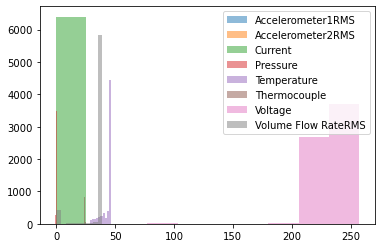

In [6]:
# Check the distributions BEFORE scaling
n_bins = 10
for i,column_name in enumerate(list(df)):
    plt.hist(df[column_name], bins=n_bins, alpha=0.5, label=column_name)
plt.legend(loc='upper right')
plt.show()

#### Looks crazy, right?! Let's scale our dimensions to the same range by applying the basic MinMax scaler that scales all values on the range of [0,1]

In [7]:
# MinMax scaler
df_minmax = (df - df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))
df_minmax.head()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2019-07-08 17:02:14,0.138698,0.294724,0.000002,0.428573,0.000000,0.007196,0.981797,0.949921
2019-07-08 17:02:32,0.145412,0.331350,0.000003,0.571430,0.007546,0.009387,0.934191,0.949300
2019-07-08 17:02:45,0.155912,0.315265,0.000002,0.571430,0.024127,0.004693,0.915367,0.974351
2019-07-08 17:02:46,0.157688,0.287348,0.000003,0.428573,0.032957,0.004693,0.891648,0.949921
2019-07-08 17:02:47,0.131556,0.308587,0.000002,0.571430,0.007937,0.001252,0.932008,0.974351


In [8]:
df.min(axis=0)

id
Accelerometer1RMS       0.032501
Accelerometer2RMS       0.052414
Current                 0.000215
Pressure               -1.257000
Temperature            28.209900
Thermocouple           23.434200
Voltage                 0.000643
Volume Flow RateRMS     0.000000
dtype: float64

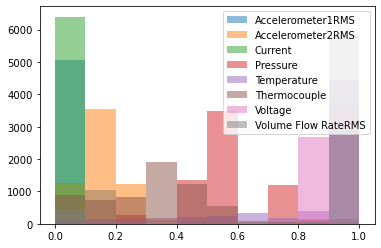

In [9]:
# Check the distributions AFTER scaling
n_bins = 10
for i,column_name in enumerate(list(df_minmax)):
    plt.hist(df_minmax[column_name], bins=n_bins, alpha=0.5, label=column_name)
plt.legend(loc='upper right')
plt.show()

#### Looks better now - all of the values are on the same scale now, what about distributions? 

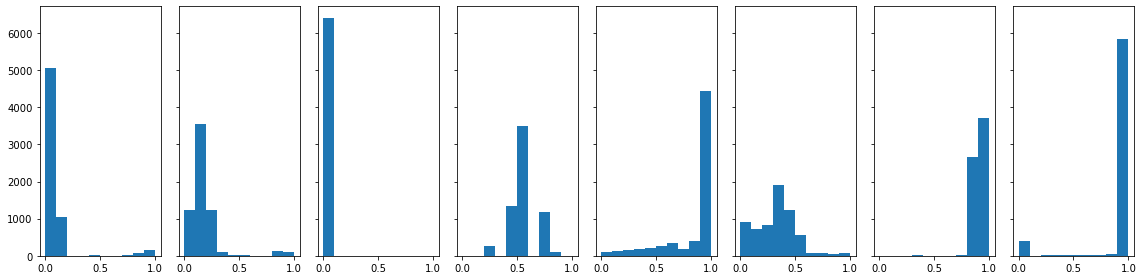

In [10]:
# Check the distributions 
n_bins = 10
subplot_n = len(list(df_minmax))
fig, axs = plt.subplots(1, subplot_n, sharey=True, tight_layout=True,figsize=(16, 4))

for i,column_name in enumerate(list(df_minmax)):
    axs[i].hist(df_minmax[column_name], bins=n_bins)

#### What do we see from the histograms
Seems like the values are distributed differently so let's apply the <b>standartization process</b> in order to get closer to the comparable Normal distribution across all dimensions. To achieve this we are going to apply the standard scaler which brings our data to the form with zero mean and standard deviation of 1

In [5]:
# apply standard scaler
df_std = (df - df.mean(axis=0))/df.std(axis=0)
df_std.head()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2019-07-08 17:02:14,0.215518,0.705457,-0.033004,-1.167732,-3.498641,-1.776967,1.442359,0.239748
2019-07-08 17:02:32,0.255118,0.934175,-0.032991,0.091413,-3.466961,-1.764773,0.596662,0.237173
2019-07-08 17:02:45,0.317043,0.833732,-0.033002,0.091413,-3.397343,-1.790903,0.262247,0.341066
2019-07-08 17:02:46,0.327513,0.659396,-0.032982,-1.167732,-3.360273,-1.790903,-0.159118,0.239748
2019-07-08 17:02:47,0.173401,0.792024,-0.033002,0.091413,-3.465317,-1.810065,0.557879,0.341066


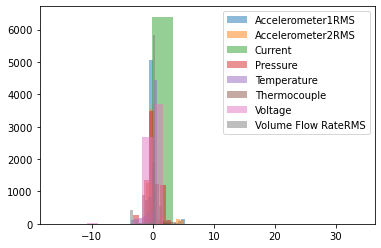

In [12]:
# Check the distributions AFTER standard scaling
n_bins = 10
for i,column_name in enumerate(list(df_std)):
    plt.hist(df_std[column_name], bins=n_bins, alpha=0.5, label=column_name)
plt.legend(loc='upper right')
plt.show()

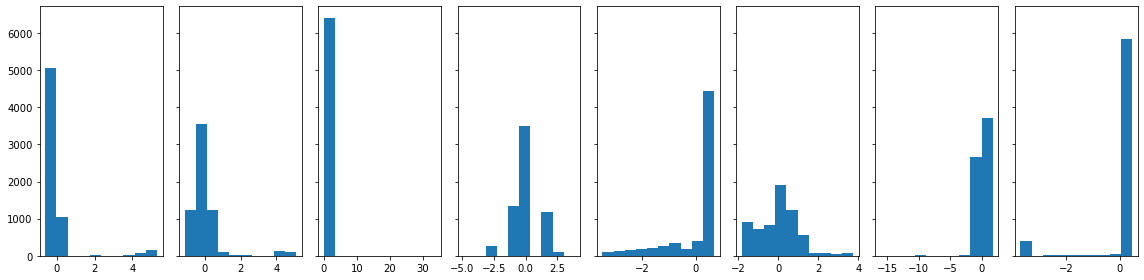

In [13]:
# Check the distributions 
n_bins = 10
subplot_n = len(list(df_std))
fig, axs = plt.subplots(1, subplot_n, sharey=True, tight_layout=True,figsize=(16, 4))

for i,column_name in enumerate(list(df_minmax)):
    axs[i].hist(df_std[column_name], bins=n_bins)

#### note that the numbers on the X axis have changed and the peaks are located at 0 for all dimensions

#### What about the 3rd preprocessing option? - Robust scaler? Is it more applicable in our case?
value = (value – median) / (p75 – p25)

In [14]:
median = df.quantile(q=0.5, axis=0)
p75 = df.quantile(q=0.75, axis=0)
p25 = df.quantile(q=0.25, axis=0)

In [15]:
p75

id
Accelerometer1RMS        0.039111
Accelerometer2RMS        0.071790
Current                  0.000859
Pressure                 0.054711
Temperature             46.038100
Thermocouple            24.108900
Voltage                237.489000
Volume Flow RateRMS     38.000000
Name: 0.75, dtype: float64

In [16]:
df_rbst = (df - median)/(p75-p25)
df_rbst.head()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2019-07-08 17:02:14,1.954167,1.684201,-0.205196,-1.0,-9.148318,-1.506872,2.060103,-0.0062
2019-07-08 17:02:32,2.119988,2.075884,0.437000,0.0,-9.075883,-1.497251,0.796701,-0.0304
2019-07-08 17:02:45,2.379299,1.903873,-0.104707,0.0,-8.916701,-1.517867,0.297113,0.9460
2019-07-08 17:02:46,2.423142,1.605321,0.854073,-1.0,-8.831941,-1.517867,-0.332371,-0.0062
2019-07-08 17:02:47,1.777800,1.832448,-0.079215,0.0,-9.072122,-1.532985,0.738763,0.9460


In [17]:
df_rbst.median(axis=0)

id
Accelerometer1RMS      0.0
Accelerometer2RMS      0.0
Current                0.0
Pressure               0.0
Temperature            0.0
Thermocouple           0.0
Voltage                0.0
Volume Flow RateRMS    0.0
dtype: float64

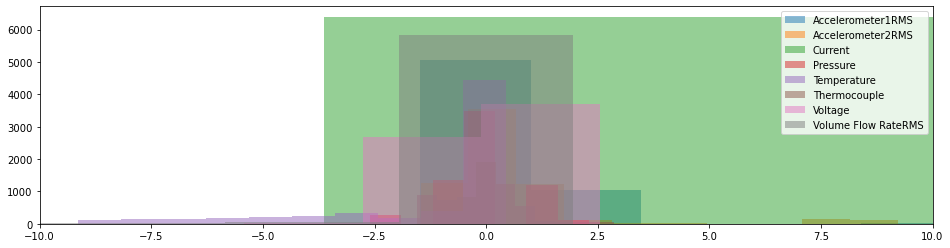

In [18]:
# Check the distributions AFTER robust scaling
plt.figure(figsize=(16, 4))
n_bins = 10
for i,column_name in enumerate(list(df_rbst)):
    plt.hist(df_rbst[column_name], bins=n_bins, alpha=0.5, label=column_name)
plt.legend(loc='upper right')
plt.xlim([-10, 10])
plt.show()

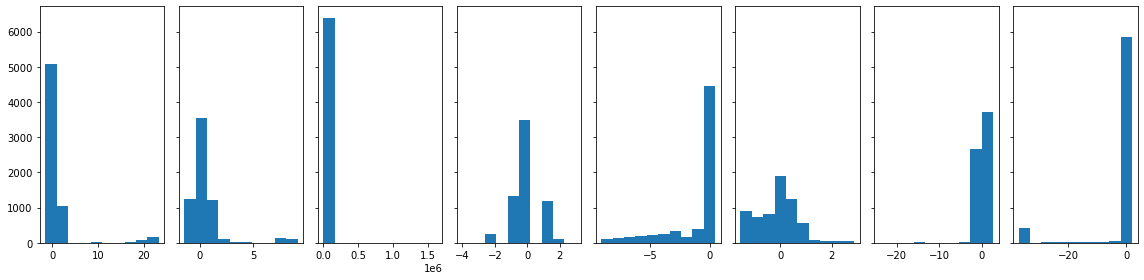

In [19]:
# Check the distributions 
n_bins = 10
subplot_n = len(list(df_rbst))
fig, axs = plt.subplots(1, subplot_n, sharey=True, tight_layout=True,figsize=(16, 4))

for i,column_name in enumerate(list(df_minmax)):
    axs[i].hist(df_rbst[column_name], bins=n_bins)

In [20]:
print(p25['Current'],p75['Current'],np.max(df['Current']),(np.max(df['Current'])-df['Current'].median())/(p75['Current']-p25['Current']))

0.0007029639999999999 0.000858932 253.297 1624026.8470070781


#### Let's plot our observations, there is small problem though - we can't plot in 8 dimensions :( Let's reduce the dimensionality by applying the most popular dimensionality reduction algorithm called PCA. We will cheat a little bit by using the sci-kit learn implementation:

![title](PCA1.png)
![title](pca2.png)
![title](pca.png)

In [1356]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(df_std)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1
0,2.949112,-1.753972
1,3.003177,-1.641817
2,3.001418,-1.689372
3,2.926659,-1.798424
4,2.956642,-1.803408


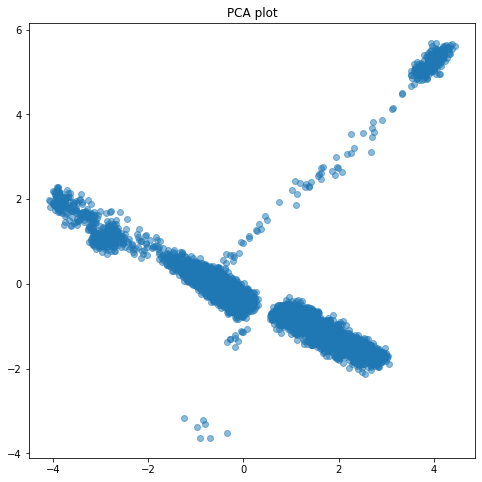

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(x_pca[0],x_pca[1],alpha=0.5)
plt.title('PCA plot')
plt.show()

In [1347]:
dir(pca)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'mean_',
 'n_components',
 'n_components_',
 'n_features_',
 'n_features_in_',
 'n_samples_',
 'noise_variance_',
 'random_state',
 'score',
 'scor

In [1359]:
pca_8 = PCA(n_components=8)
x_pca = pca_8.fit_transform(df_std)

In [1361]:
np.sum(pca_8.explained_variance_ratio_)

1.0

In [1362]:
pca_7 = PCA(n_components=7)
x_pca = pca_7.fit_transform(df_std)

In [1363]:
np.sum(pca_7.explained_variance_ratio_)

0.9975530537070842

In [1364]:
np.sum(pca.explained_variance_ratio_)

0.503737376556655

#### Looks awesome! I think I can spot some anomalies already :D Let's get an alternative view with a different dimensionality reduction algorithm t-SNE:

In [23]:
tsne = TSNE(n_components=2,perplexity=2) #perplexity is the key hyperparameter
x_tsne_2 = tsne.fit_transform(df_std)
x_tsne_2 = pd.DataFrame(x_tsne_2)
x_tsne_2.head()

,0,1
0,-91.836380,19.507740
1,-71.843979,22.422939
2,-72.244499,20.472784
3,24.698341,-43.055573
4,-71.910393,22.314276


In [24]:
tsne_5 = TSNE(n_components=2,perplexity=5) #perplexity is the key hyperparameter
x_tsne_5 = tsne_5.fit_transform(df_std)
x_tsne_5 = pd.DataFrame(x_tsne_5)

In [25]:
tsne_10 = TSNE(n_components=2,perplexity=10) #perplexity is the key hyperparameter
x_tsne_10 = tsne_10.fit_transform(df_std)
x_tsne_10 = pd.DataFrame(x_tsne_10)

In [26]:
tsne_20 = TSNE(n_components=2,perplexity=20) #perplexity is the key hyperparameter
x_tsne_20 = tsne_20.fit_transform(df_std)
x_tsne_20 = pd.DataFrame(x_tsne_20)

In [27]:
tsne_30 = TSNE(n_components=2,perplexity=30) #perplexity is the key hyperparameter
x_tsne_30 = tsne_30.fit_transform(df_std)
x_tsne_30 = pd.DataFrame(x_tsne_30)

In [28]:
tsne_50 = TSNE(n_components=2,perplexity=50) #perplexity is the key hyperparameter
x_tsne_50 = tsne_50.fit_transform(df_std)
x_tsne_50 = pd.DataFrame(x_tsne_50)

In [29]:
tsne_100 = TSNE(n_components=2,perplexity=100) #perplexity is the key hyperparameter
x_tsne_100 = tsne_100.fit_transform(df_std)
x_tsne_100 = pd.DataFrame(x_tsne_100)

In [30]:
tsne_200 = TSNE(n_components=2,perplexity=200) #perplexity is the key hyperparameter
x_tsne_200 = tsne_200.fit_transform(df_std)
x_tsne_200 = pd.DataFrame(x_tsne_200)

In [31]:
tsne_300 = TSNE(n_components=2,perplexity=300) #perplexity is the key hyperparameter
x_tsne_300 = tsne_300.fit_transform(df_std)
x_tsne_300 = pd.DataFrame(x_tsne_300)

In [32]:
tsne_500 = TSNE(n_components=2,perplexity=500) #perplexity is the key hyperparameter
x_tsne_500 = tsne_500.fit_transform(df_std)
x_tsne_500 = pd.DataFrame(x_tsne_500)

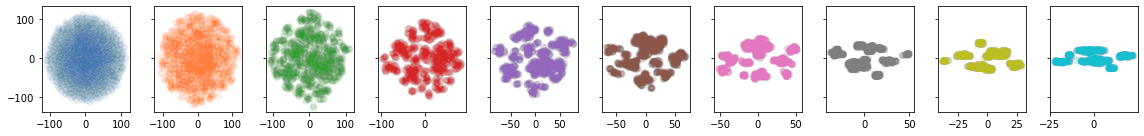

In [33]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
perplexity = [x_tsne_2,x_tsne_5,x_tsne_10,x_tsne_20,x_tsne_30,x_tsne_50,x_tsne_100,x_tsne_200,x_tsne_300,x_tsne_500]
subplot_n = len(perplexity)
fig, axs = plt.subplots(1, subplot_n, sharey=True, tight_layout=True,figsize=(16, 2))
for i,perp in enumerate(perplexity):
    axs[i].scatter(perp[0],perp[1],alpha=0.01,c=colors[i]) #setting a small alpha to improve the visibility of density
plt.show()

#### Larger perplexity gives more sense in our case as it gives less clusters to achieve our goal of identifying a small number of issue TYPES. The interesting observation, however is that the number of clusters is not changing much after a specific threshold

#### What about correlations among the dimensions? Let's take the easy path first

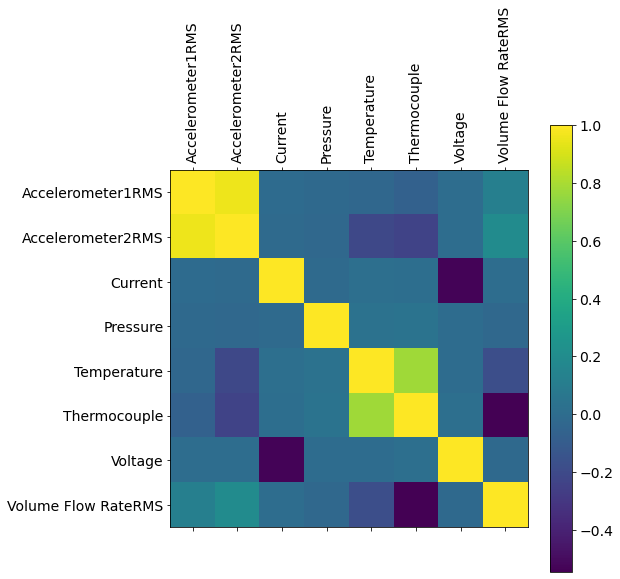

In [34]:
f = plt.figure(figsize=(8, 8))
plt.matshow(df_std.corr(), fignum=f.number)
plt.xticks(range(len(df_std.columns)), df.columns, fontsize=14, rotation=90)
plt.yticks(range(len(df_std.columns)), df.columns,  fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);

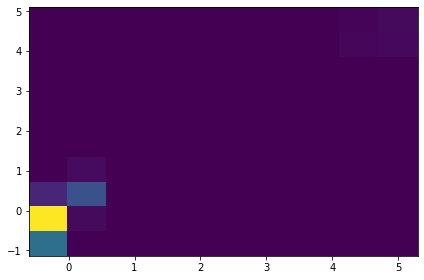

In [35]:
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(df_std['Accelerometer1RMS'], df_std['Accelerometer2RMS'])

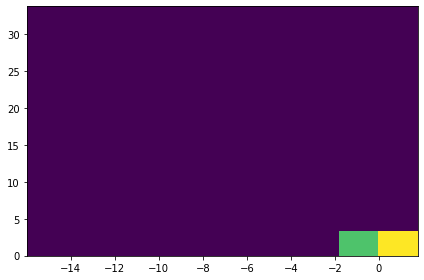

In [36]:
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(df_std['Voltage'], df_std['Current'])

### Pearson correlation is based on covariance, for the later needs let's calculate it as well

In [37]:
df_std.cov()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
id,,,,,,,,
Accelerometer1RMS,1.000000,0.961935,-0.007857,-0.017103,-0.028357,-0.063111,0.009009,0.124409
Accelerometer2RMS,0.961935,1.000000,-0.010176,-0.026120,-0.210394,-0.234495,0.006329,0.199950
Current,-0.007857,-0.010176,1.000000,-0.014098,0.017977,0.010058,-0.528062,0.008378
Pressure,-0.017103,-0.026120,-0.014098,1.000000,0.037084,0.040263,0.003384,-0.025920
Temperature,-0.028357,-0.210394,0.017977,0.037084,1.000000,0.781465,0.003102,-0.171644
Thermocouple,-0.063111,-0.234495,0.010058,0.040263,0.781465,1.000000,0.019938,-0.545624
Voltage,0.009009,0.006329,-0.528062,0.003384,0.003102,0.019938,1.000000,-0.015634
Volume Flow RateRMS,0.124409,0.199950,0.008378,-0.025920,-0.171644,-0.545624,-0.015634,1.000000


#### For the later needs we will need to make it positive-definite, but let's keep as is for now 

#### Let's get the covariance and correlation matrixes again, but honestly:

cov(X, Y) = sum((x - mean(X)) * (y - mean(Y)) ) * 1/(n-1)

In [38]:
# Let's calculate the cov for the Accelerometer1RMS,Accelerometer2RMS pair. The answer matches the one given by pandas!
cov_A1_A2 = ((df_std['Accelerometer1RMS'] - df_std['Accelerometer1RMS'].mean())*(df_std['Accelerometer2RMS'] - df_std['Accelerometer2RMS'].mean())).sum()*1/(len(df_std)-1)
print(cov_A1_A2,df_std.cov()['Accelerometer1RMS']['Accelerometer2RMS'])

0.9619350887940102 0.9619350887940101


In [39]:
#Pearson's corr = cov(X, Y) / (std(X) * std(Y))

In [40]:
#Matches the pandas result as well!
print(cov_A1_A2 / (df_std['Accelerometer1RMS'].std() * df_std['Accelerometer2RMS'].std()),
      df_std.corr()['Accelerometer1RMS']['Accelerometer2RMS'])

0.9619350887940105 0.9619350887940104


#### Let's get a Multivariate distribution and plot the log probability for each OBSERVATION in a simple way!

In [41]:
cov = torch.tensor(df_std.cov().values)
#let's get a positive semi-definitive cov matrix
#cov = torch.matmul(cov,cov.T)

In [42]:
# we will use pytoch distributions library for that
dist = MultivariateNormal(torch.zeros(cov.shape[0]),cov)

In [43]:
# let's get the log probabilities 
inputs = torch.tensor(df_std.values)
log_probs = dist.log_prob(inputs).float()

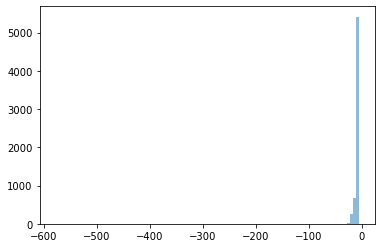

In [44]:
n_bins = 100
plt.hist(log_probs, bins=n_bins, alpha=0.5)
plt.show()

In [45]:
# Let's get the top 5% of the anonalous entries 
q = torch.tensor([0.05, 1])
quantiles = torch.quantile(log_probs,q)

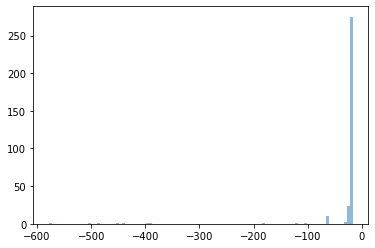

In [46]:
n_bins = 100
plt.hist(log_probs[log_probs <= quantiles[0]], bins=n_bins, alpha=0.5)
plt.show()

#### What are those entries? 

In [47]:
predicted_anomalies = df_std[(log_probs <= quantiles[0]).detach().numpy()]
predicted_anomalies.head()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2019-07-08 17:02:56,0.253367,0.506880,-0.033011,2.609703,-3.406137,-1.817033,0.965373,0.133354
2019-07-08 17:04:52,0.051903,0.590438,-0.033032,-3.686022,-3.031072,-1.716694,-0.418245,0.341034
2019-07-08 17:06:46,0.147028,0.463788,-0.033000,-3.686022,-2.630517,-1.670357,1.230780,0.341034
2019-07-08 17:59:06,-0.289981,-0.454690,-0.033024,0.091413,0.271034,-0.380577,-8.991709,0.237173
2019-07-08 17:59:07,-0.363128,-0.107610,-0.033024,0.091413,0.271034,-0.370125,-8.991709,0.237173


#### Let's validate our findings

In [6]:
# get the true anomalies according to the dataset specification (WITHOUT GRADUAL INTRODUCTION/DISSAPEARANCE OF ANOMALIES)
true_anomalies = df_std[((df_std.index>='2019-07-08 18:39:22') & (df_std.index<='2019-07-08 18:42:32')) | 
                        ((df_std.index>='2019-07-08 18:45:49') & (df_std.index<='2019-07-08 18:46:51')) | 
                        ((df_std.index>='2019-07-08 19:07:37') & (df_std.index<='2019-07-08 19:10:45')) | 
                        ((df_std.index>='2019-07-08 19:16:24') & (df_std.index<='2019-07-08 19:19:15'))]

In [343]:
print('# of true anomalies:',len(true_anomalies),'# of predicted anomalies:',len(predicted_anomalies))

# of true anomalies: 592 # of predicted anomalies: 321


#### Looks like we don't have enough anomalies!! (cheating here) Let's update the quantiles

In [50]:
# Let's get the top 5% of the anonalous entries 
q_2 = torch.tensor([0.09, 1])
quantiles_2 = torch.quantile(log_probs,q_2)
predicted_anomalies_2 = df_std[(log_probs <= quantiles_2[0]).detach().numpy()]
len(predicted_anomalies_2)

577

In [51]:
det_anomalies = len(set(true_anomalies.index).intersection(set(predicted_anomalies_2.index)))
print('# of detected anomalies:', det_anomalies)
print(f'That is {det_anomalies/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 436
That is 0.7364864864864865% of all anomalies


#### What about precision, recall and F1 score of the anomaly predictions vs true anomalies? NOTE: give more details here

In [52]:
precision = det_anomalies/len(predicted_anomalies_2)
recall = det_anomalies/len(true_anomalies)
F1 = 2*((precision*recall)/(precision+recall))
print(precision,recall,F1)

0.755632582322357 0.7364864864864865 0.7459366980325065


#### In a multi-class classification problems, what is the difference between micro and macro averaging?

#### What will happen if we change the quantile? 

In [53]:
# Let's get the top 5% of the anonalous entries 
q_3 = torch.tensor([0.15, 1])
quantiles_3 = torch.quantile(log_probs,q_3)
predicted_anomalies_3 = df_std[(log_probs <= quantiles_3[0]).detach().numpy()]
det_anomalies_3 = len(set(true_anomalies.index).intersection(set(predicted_anomalies_3.index)))
precision_2 = det_anomalies_3/len(predicted_anomalies_3)
recall_2 = det_anomalies_3/len(true_anomalies)
F1_2 = 2*((precision_2*recall_2)/(precision_2+recall_2))
print(precision_2,recall_2,F1_2)

0.6129032258064516 0.9949324324324325 0.7585318737926595


In [54]:
np.linspace(0.05,0.2,15)

array([0.05      , 0.06071429, 0.07142857, 0.08214286, 0.09285714,
       0.10357143, 0.11428571, 0.125     , 0.13571429, 0.14642857,
       0.15714286, 0.16785714, 0.17857143, 0.18928571, 0.2       ])

In [55]:
t = np.linspace(0.05,0.2,15)
precisions = []
recalls = []
f1 = []
for x in t:
    q =  torch.quantile(log_probs,x)
    pred = df_std[(log_probs <= q).detach().numpy()]
    detected = len(set(true_anomalies.index).intersection(set(pred.index)))
    precisions.append(detected/len(pred))
    recalls.append(detected/len(true_anomalies))
    f1.append(2*((precisions[-1]*recalls[-1])/(precisions[-1]+recalls[-1])))

#### How to choose the right quantile (given the knowledge of the true anomalies) IMPORTANT: as mentioned we wanna split our dataset to validation and test pieces, hyperparameter (q) tuning is done on the validation piece, test piece is for the final tests

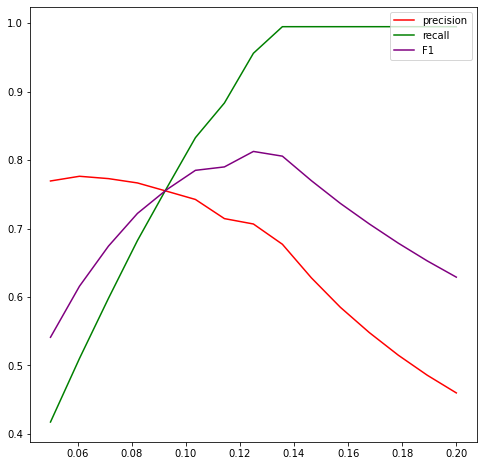

In [56]:
names = ['precision', 'recall', 'F1']
plt.figure(figsize=(8,8))
plt.plot(t,precisions,'r',label=names[0])
plt.plot(t,recalls,'g',label=names[1])
plt.plot(t,f1,'purple',label=names[2])
plt.legend(loc='upper right')
plt.show()

#### It is always about finding the right balance: we decreased the precision, but significantly increased the recall thus slightly improving the F1 score. The quantile is a hyperparameter here which should be tuned. Let's do so:

#### Wait a minute! What is WRONG about what I am doing? How to fix that?

In [ ]:
#### Promised performance tests for the robust scaler

In [58]:
df_rbst.cov()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
id,,,,,,,,
Accelerometer1RMS,17.535049,6.898158,-1.578746e+03,-0.056878,-0.271510,-0.208506,0.056358,4.896063
Accelerometer2RMS,6.898158,2.932701,-8.362467e+02,-0.035524,-0.823830,-0.316829,0.016191,3.218070
Current,-1578.746437,-836.246685,2.302780e+09,-537.295894,1972.450622,380.785403,-37856.276939,3778.560195
Pressure,-0.056878,-0.035524,-5.372959e+02,0.630737,0.067342,0.025228,0.004016,-0.193463
Temperature,-0.271510,-0.823830,1.972451e+03,0.067342,5.228048,1.409735,0.010595,-3.688403
Thermocouple,-0.208506,-0.316829,3.807854e+02,0.025228,1.409735,0.622467,0.023500,-4.045692
Voltage,0.056358,0.016191,-3.785628e+04,0.004016,0.010595,0.023500,2.231787,-0.219498
Volume Flow RateRMS,4.896063,3.218070,3.778560e+03,-0.193463,-3.688403,-4.045692,-0.219498,88.324618


In [59]:
cov_rbst = torch.tensor(df_rbst.cov().values)
u = torch.tensor(df_rbst.mean(axis=0).values) #u is the expectation (les formally mean)

In [60]:
dist_rbst = MultivariateNormal(u,cov_rbst)
# let's get the log probabilities 
inputs_rbst = torch.tensor(df_rbst.values)
log_probs_rbst = dist_rbst.log_prob(inputs_rbst).float()

In [61]:
q_2 = torch.tensor([0.09, 1])
quantiles_rbst = torch.quantile(log_probs_rbst,q_2)
predicted_anomalies_rbst = df_std[(log_probs_rbst <= quantiles_rbst[0]).detach().numpy()]
len(predicted_anomalies_rbst) #It is the SAME because the quantile is the same, duh

577

In [62]:
det_anomalies_rbst = len(set(true_anomalies.index).intersection(set(predicted_anomalies_rbst.index)))
print('# of detected anomalies:', det_anomalies_rbst)
print(f'That is {det_anomalies_rbst/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 436
That is 0.7364864864864865% of all anomalies


#### The results are exactly the same with the robust scaler

#### Let's visualize the true anomalies

In [63]:
colors = df_std.index.isin(true_anomalies.index).astype('int')

In [64]:
colors[df_std.index.isin(set(true_anomalies.index).intersection(set(predicted_anomalies_2.index)))] = 2

In [65]:
np.sum(colors==1)

156

In [66]:
np.sum(colors==2)

436

#### PCA:

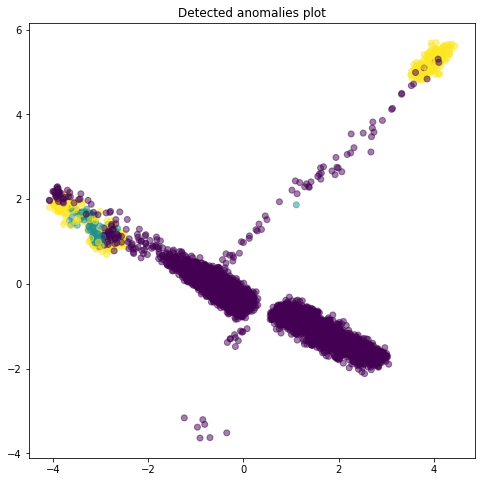

In [67]:
plt.figure(figsize=(8, 8))
plt.scatter(x_pca[0],x_pca[1],alpha=0.5,c=colors)
plt.title('Detected anomalies plot')
plt.show()

#### t-SNE:

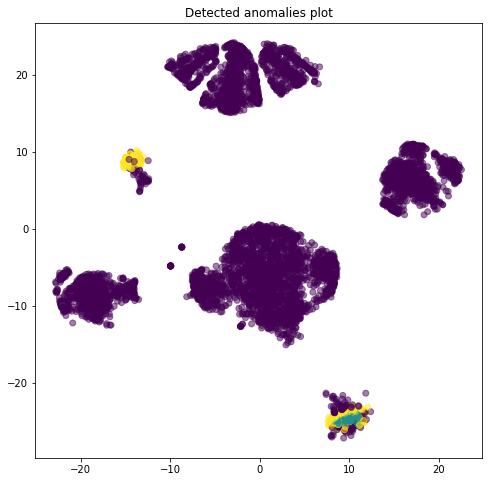

In [68]:
plt.figure(figsize=(8, 8))
plt.scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=colors)
plt.title('Detected anomalies plot')
plt.show()

#### Let's calculate probabilities instead of log probabilities available in pytorch:

In [69]:
#code by James D. McCaffrey
def mvn_pdf(x, u, cov):
  # x, u are like (3,) or (3,1)
  # this function can fail in multiple ways
    k = len(u)               # scalar like 3
    uu = u.reshape(k, 1)     # like 3x1
    xx = x.reshape(k, 1)     # like 3x1

    t1 = (2 * np.pi)**k          # scalar
    t2 = np.linalg.det(cov)      # scalar
    t3 = 1.0 / np.sqrt(t1 * t2)  # scalar 

    t4 = (xx - uu).T          # shape like 1x3 
    t5 = np.linalg.inv(cov)   # like 3x3
    t6 = (xx - uu)            # like 3x1
    t7 = -0.5 * (np.dot(t4,t5).dot(t6))
    #             1x3  3x3     3x1 = 1x1
    result = t3 * np.exp(t7)  # 1x1
    return result[0][0]

In [70]:
cov = df_std.cov().values
probs = np.apply_along_axis(lambda x: mvn_pdf(x,np.zeros(x.shape[0]),cov),1,df_std.values)

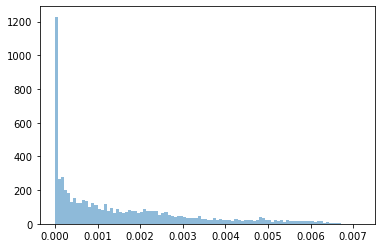

In [71]:
n_bins = 100
plt.hist(probs, bins=n_bins, alpha=0.5)
plt.show()

In [72]:
predicted_anomalies_probs = df_std[probs <= np.quantile(probs,0.09)]

In [73]:
len(predicted_anomalies_probs)

577

In [74]:
det_anomalies_probs = len(set(true_anomalies.index).intersection(set(predicted_anomalies_probs.index)))
print('# of detected anomalies:', det_anomalies_probs)
print(f'That is {det_anomalies_probs/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 436
That is 0.7364864864864865% of all anomalies


In [75]:
precision = det_anomalies_probs/len(predicted_anomalies_probs)
recall = det_anomalies_probs/len(true_anomalies)
F1 = 2*((precision*recall)/(precision+recall))
print(precision,recall,F1)

0.755632582322357 0.7364864864864865 0.7459366980325065


#### Not surprisingly the results are the same as with log probabilities

#### Can we improve the results?! About that in the next lextures, meanwhile let's take a look at a vectorization sample:

In [728]:
m1 = np.random.randn(1000,40,30)
m2 = np.random.rand(10,30,20)

In [729]:
#out.shape = (1000,40,20) 

In [760]:
%%timeit
out = np.einsum('nij,kje->nie', m1,m2)

265 ms ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [731]:
m1_t = torch.randn(1000,40,30).to(cuda0)
m2_t = torch.randn(10,30,20).to(cuda0)

In [732]:
%%timeit
out_t = torch.einsum('nij,kje->nie', m1_t,m2_t)

141 µs ± 569 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Lecture 2

### Does it make sense to detect anomalies in lower-dimensional space?

In [148]:
cuda0 = torch.device('cuda:0')

In [87]:
X = np.linspace(np.min(x_tsne_500[0]),np.max(x_tsne_500[0]),500)
Y = np.linspace(np.min(x_tsne_500[1]),np.max(x_tsne_500[1]),500)

In [88]:
xx,yy = np.meshgrid(X,Y)

In [89]:
x = np.vstack((xx.flatten(),yy.flatten()))

In [90]:
u = x_tsne_500.mean(axis=0).values
cov = x_tsne_500.cov()
p = np.apply_along_axis(lambda x: mvn_pdf(x, u, cov),0,x)

In [91]:
p = p.reshape((500,500))

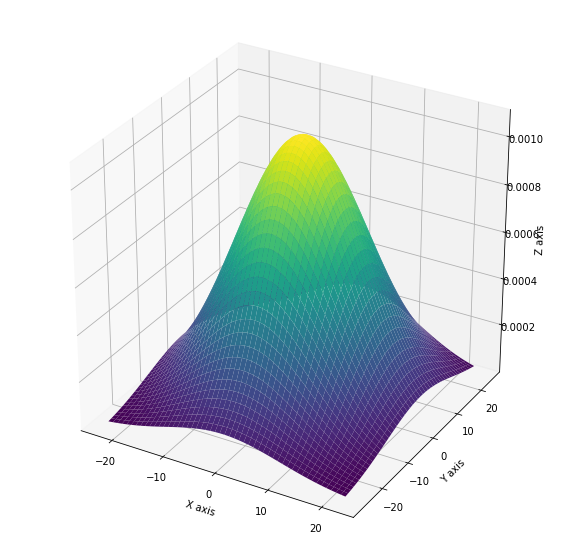

In [92]:
#Make a 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, p,cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [761]:
import mayavi.mlab as mlab
import numpy as np
x,y = np.mgrid[-1:1:0.001, -1:1:0.001]
z = x**2+y**2
s = mlab.mesh(x, y, z)
alpha = 30  # degrees
mlab.view(azimuth=0, elevation=90, roll=-90+alpha)

mlab.show()

In [109]:
probs_tsne = np.apply_along_axis(lambda x: mvn_pdf(x,u,cov),1,x_tsne_500.values)

In [110]:
np.quantile(probs_tsne,0.09)

0.0001357838275609949

In [111]:
predicted_anomalies_tsne = df_std[probs_tsne <= np.quantile(probs_tsne,0.09)]

In [112]:
len(predicted_anomalies_tsne)

577

In [113]:
det_anomalies_tsne = len(set(true_anomalies.index).intersection(set(predicted_anomalies_tsne.index)))
print('# of detected anomalies:', det_anomalies_tsne)
print(f'That is {det_anomalies_tsne/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 342
That is 0.5777027027027027% of all anomalies


### Normality test

In [301]:
#Henze-Zirkler Multivariate Normality Test
from pingouin import multivariate_normality 

In [307]:
#perform Anderson-Darling Test 
from scipy.stats import anderson

In [762]:
#Ideal normal distribution
normal_dist = Normal(0,1)

In [784]:
# Samples from the ideal normal distribution
samples = normal_dist.sample(torch.tensor([10000]))

In [767]:
samples = samples.detach().numpy()

In [768]:
#output of the tests (hypothesis is NOT rejected):
anderson(samples)

AndersonResult(statistic=0.47287500411403016, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [777]:
#preparing a positive-definite random cov matrix
t = torch.randn((8,8))
t = torch.matmul(t,t.T)

In [778]:
#Ideal multivariate Normal distribution
multivar_dist = MultivariateNormal(torch.zeros(8),t)

In [779]:
#Sample from the ideal Multivariate Normal
samples_multivariate = multivar_dist.sample(torch.tensor([10000]))

In [786]:
# Output of the test for multivariate normal ((hypothesis is NOT rejected))
multivariate_normality(samples_multivariate, alpha=.05)

HZResults(hz=0.997375255428509, pval=0.3768587269206894, normal=True)

In [309]:
# Anderson-Darling Test on the real data (hypothesis is rejected for all dimensions)
for name in df_std.columns:
    print(name,':',anderson(df_std[name]))

Accelerometer1RMS : AndersonResult(statistic=1524.9261091172566, critical_values=array([0.576, 0.656, 0.787, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Accelerometer2RMS : AndersonResult(statistic=800.2655479984005, critical_values=array([0.576, 0.656, 0.787, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Current : AndersonResult(statistic=2471.752440232587, critical_values=array([0.576, 0.656, 0.787, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Pressure : AndersonResult(statistic=462.28616090090327, critical_values=array([0.576, 0.656, 0.787, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Temperature : AndersonResult(statistic=945.4600292008818, critical_values=array([0.576, 0.656, 0.787, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Thermocouple : AndersonResult(statistic=65.87345230191659, critical_values=array([0.576, 0.656, 0.787, 0.917, 1.0

In [302]:
#Henze-Zirkler Multivariate Normality Test on th real data (hypothesis is rejected)
multivariate_normality(df_std, alpha=.05)

HZResults(hz=96.25504640693677, pval=0.0, normal=False)

### Mixture Models
#### Hypothesis: we have a mixture of finite # of distributions with unknown parameters 
#### Goal: obtain the # of mixtures and estimate the parameters

In [ ]:
#get the number of mixtures:
GaussianMixture(n_components=2, random_state=0).

![title](bic.png)
![title](bic_2.png)

In [132]:
bic = []
for n in range(1,50):
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n)
    gmm.fit(df_std)
    bic.append(gmm.bic(df_std))

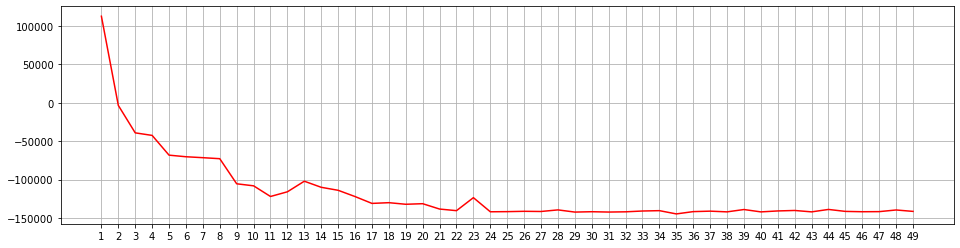

In [140]:
plt.figure(figsize=(16,4))
plt.plot(list(range(1,50)),bic,'r',label='bic')
plt.xticks(ticks=list(range(1,50)))
plt.grid(True)
plt.show()

In [161]:
gmm = GaussianMixture(n_components=1).fit(df_std)

In [160]:
#gmm.means_[0,:]

In [165]:
#gmm.covariances_[0,:,:]

In [162]:
w_log_probs = gmm.score_samples(df_std)

In [163]:
predicted_anomalies_gmm = df_std[w_log_probs <= np.quantile(w_log_probs,0.09)]

In [164]:
det_anomalies_gmm  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_gmm.index)))
print('# of detected anomalies:', det_anomalies_gmm)
print(f'That is {det_anomalies_gmm/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 436
That is 0.7364864864864865% of all anomalies


In [297]:
covariances = ['spherical', 'tied', 'diag','full']
accuracies = {'spherical':[], 'tied':[], 'diag':[],'full':[]}
for i in range(1,24):
    for cov in covariances:
        gmm = GaussianMixture(n_components=i,covariance_type= cov,tol=1e-4,max_iter=200).fit(df_std)
        w_log_probs = gmm.score_samples(df_std)
        predicted_anomalies_gmm = df_std[w_log_probs <= np.quantile(w_log_probs,0.09)]
        det_anomalies_gmm  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_gmm.index)))
        accuracies[cov].append(det_anomalies_gmm/len(true_anomalies))

In [ ]:
covariances = ['spherical', 'tied', 'diag','full']
plt.figure(figsize=(16,4))
plt.plot(list(range(1,24)),accuracies[covariances[0]],'g',label=covariances[0])
plt.plot(list(range(1,24)),accuracies[covariances[1]],'r',label=covariances[1])
plt.plot(list(range(1,24)),accuracies[covariances[2]],'y',label=covariances[2])
plt.plot(list(range(1,24)),accuracies[covariances[3]],'b',label=covariances[3])
plt.xticks(ticks=list(range(1,24)))
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

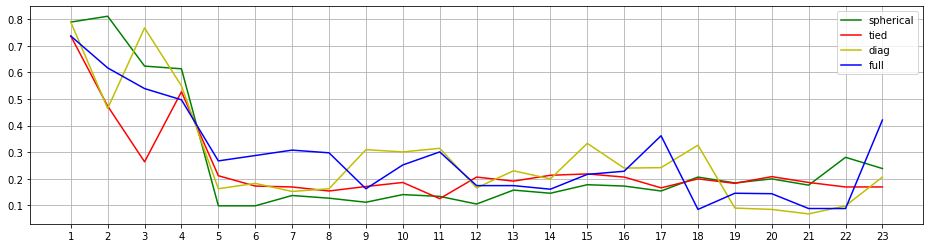

In [249]:
covariances = ['spherical', 'tied', 'diag','full']
plt.figure(figsize=(16,4))
plt.plot(list(range(1,24)),accuracies[covariances[0]],'g',label=covariances[0])
plt.plot(list(range(1,24)),accuracies[covariances[1]],'r',label=covariances[1])
plt.plot(list(range(1,24)),accuracies[covariances[2]],'y',label=covariances[2])
plt.plot(list(range(1,24)),accuracies[covariances[3]],'b',label=covariances[3])
plt.xticks(ticks=list(range(1,24)))
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [313]:
gmm = GaussianMixture(n_components=2,covariance_type= 'spherical',tol=1e-4).fit(df_std)

In [256]:
w_log_probs = gmm.score_samples(df_std)
predicted_anomalies_gmm = df_std[w_log_probs <= np.quantile(w_log_probs,0.09)]
det_anomalies_gmm  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_gmm.index)))
det_anomalies_gmm = len(set(true_anomalies.index).intersection(set(predicted_anomalies_gmm.index)))
print('# of detected anomalies:', det_anomalies_gmm)
print(f'That is {det_anomalies_gmm/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 480
That is 0.8108108108108109% of all anomalies


In [260]:
precision = det_anomalies_gmm/len(predicted_anomalies_gmm)
recall = det_anomalies_gmm/len(true_anomalies)
F1 = 2*((precision*recall)/(precision+recall))
print(precision,recall,F1)

0.8318890814558059 0.8108108108108109 0.8212147134302823


In [319]:
t = np.linspace(0.05,0.2,15)
precisions = []
recalls = []
f1 = []
for x in t:
    pred = df_std[w_log_probs <= np.quantile(w_log_probs,x)]
    detected = len(set(true_anomalies.index).intersection(set(pred.index)))
    precisions.append(detected/len(pred))
    recalls.append(detected/len(true_anomalies))
    f1.append(2*((precisions[-1]*recalls[-1])/(precisions[-1]+recalls[-1])))

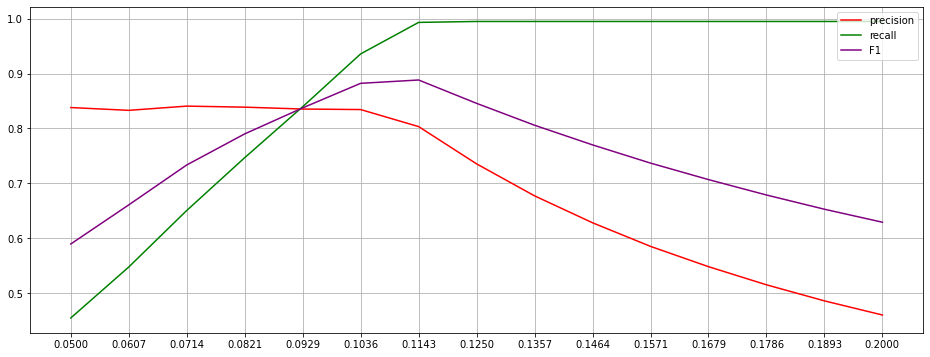

In [324]:
names = ['precision', 'recall', 'F1']
plt.figure(figsize=(16,6))
plt.plot(t,precisions,'r',label=names[0])
plt.plot(t,recalls,'g',label=names[1])
plt.plot(t,f1,'purple',label=names[2])
plt.legend(loc='upper right')
plt.xticks(ticks=np.linspace(0.05,0.2,15))
plt.grid(True)
plt.show()

In [325]:
w_log_probs = gmm.score_samples(df_std)
predicted_anomalies_gmm = df_std[w_log_probs <= np.quantile(w_log_probs,0.11)]
det_anomalies_gmm = len(set(true_anomalies.index).intersection(set(predicted_anomalies_gmm.index)))
print('# of detected anomalies:', det_anomalies_gmm)
print(f'That is {det_anomalies_gmm/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 581
That is 0.981418918918919% of all anomalies


In [787]:
precision = det_anomalies_gmm/len(predicted_anomalies_gmm)
recall = det_anomalies_gmm/len(true_anomalies)
F1 = 2*((precision*recall)/(precision+recall))
print(precision,recall,F1)

0.8241134751773049 0.981418918918919 0.8959136468774094


In [327]:
np.sum(colors==1)

112

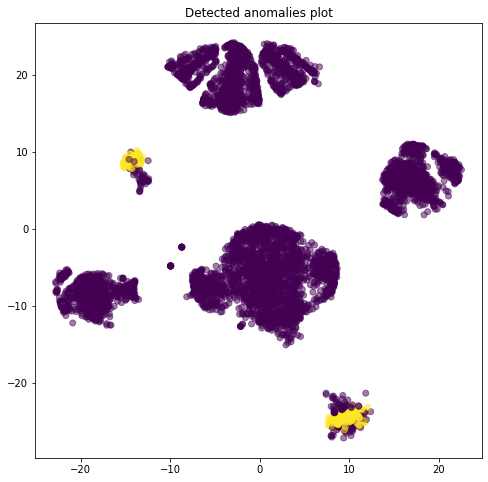

In [789]:
colors = df_std.index.isin(true_anomalies.index).astype('int')
colors[df_std.index.isin(set(true_anomalies.index).intersection(set(predicted_anomalies_gmm.index)))] = 2
plt.figure(figsize=(8, 8))
plt.scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=colors)
plt.title('Detected anomalies plot')
plt.show()

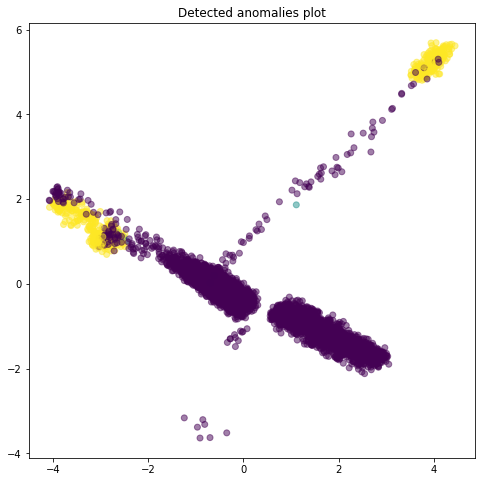

In [790]:
plt.figure(figsize=(8, 8))
plt.scatter(x_pca[0],x_pca[1],alpha=0.5,c=colors)
plt.title('Detected anomalies plot')
plt.show()

In [382]:
dist_2=Normal(0,1)

In [383]:
log_probs_normal = dist_2.log_prob(torch.tensor(df_std.values)).detach().numpy()

In [384]:
predicted_anomalies_norm = df_std[log_probs_normal <= np.quantile(log_probs_normal,0.015)]
det_anomalies_norm  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_norm.index)))
print('# of detected anomalies:', det_anomalies_norm)
print(f'That is {det_anomalies_norm/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 587
That is 0.9915540540540541% of all anomalies


In [387]:
t = np.linspace(0.005,0.02,10)
precisions = []
recalls = []
f1 = []
for x in t:
    pred = df_std[log_probs_normal <= np.quantile(log_probs_normal,x)]
    detected = len(set(true_anomalies.index).intersection(set(pred.index)))
    precisions.append(detected/len(pred))
    recalls.append(detected/len(true_anomalies))
    f1.append(2*((precisions[-1]*recalls[-1])/(precisions[-1]+recalls[-1])))

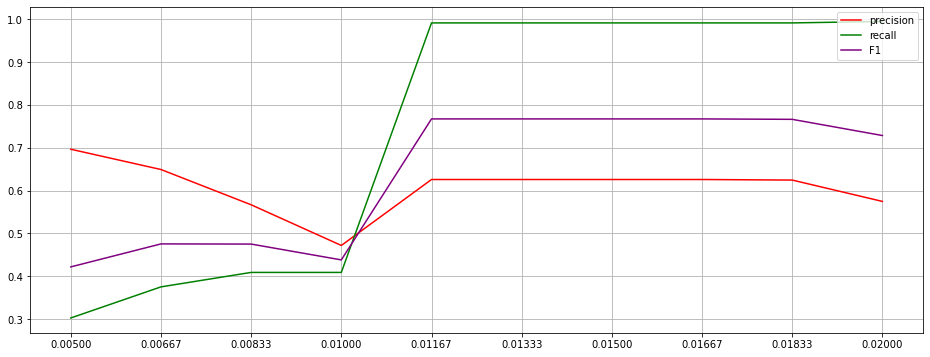

In [389]:
names = ['precision', 'recall', 'F1']
plt.figure(figsize=(16,6))
plt.plot(t,precisions,'r',label=names[0])
plt.plot(t,recalls,'g',label=names[1])
plt.plot(t,f1,'purple',label=names[2])
plt.legend(loc='upper right')
plt.xticks(ticks=np.linspace(0.005,0.02,10))
plt.grid(True)
plt.show()

In [881]:
class GaussianMixture(nn.Module):
    def __init__(self,n_components,dims): #, dropout=0.1
        super(GaussianMixture, self).__init__()
        self.mu = nn.parameter.Parameter(torch.randn((n_components,dims)),requires_grad=True) #normally dist
        self.sigmasq = nn.parameter.Parameter(torch.rand(n_components),requires_grad=True) #uniformally dist on the range [0,1]
        self.mixture = nn.Linear(dims, n_components)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        return self.softmax(torch.sigmoid(self.mixture(x)))

In [1240]:
#def gaussian_pdf(x, mu, sigmasq):
#    # NOTE: Replaced with MultivariateNormal from torch.distributions
#    pdf =  (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp(torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2))
#    return pdf

In [1567]:
#torch.diagonal(torch.diag(torch.ones(8))*0.3) #sigmasq

tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000])

In [1171]:
def calculate_loss(mu,sigmasq,mix,x):
    losses = torch.zeros(x.shape[0],device = cuda0)
    k = mix.shape[1]
    for i in range(k):  # To Do: put k versions for method and absolute, add loss proportionally likelihood
        #likelihood_z_x = gaussian_pdf(x, mu[i,:], torch.exp(sigmasq[i]))
        dist = MultivariateNormal(mu[i,:],torch.diag(torch.ones(x.shape[1]).to(cuda0)*torch.exp(sigmasq[i])))
        likelihood_z_x = dist.log_prob(x)
        #print(likelihood_z_x.shape)
        losses += mix[:,i] * likelihood_z_x
    return torch.mean(-losses)
    #return torch.mean(-(torch.log(losses)))

In [871]:
data = torch.tensor(df_std.values).float().to(cuda0)

In [872]:
data_batches = torch.split(data,32)

In [1239]:
model = GaussianMixture(2,8).to(cuda0)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
for epoch in range(3000):
    optimizer.zero_grad()
    mix = model(data)
    loss = calculate_loss(model.mu,model.sigmasq,mix,data)
    #print(loss)
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    if epoch%100==0:
        #print(model.mu)
        #print(model.sigmasq)
        print(loss.item())

13.490649223327637
13.102314949035645
12.73658275604248
12.384943008422852
12.106840133666992
11.870481491088867
11.673754692077637
11.5133056640625
11.384248733520508
11.280683517456055
11.196918487548828
11.128931999206543
11.07436752319336
11.031150817871094
10.997177124023438
10.970608711242676
10.949917793273926
10.93385124206543
10.921377182006836
10.911653518676758
10.904013633728027
10.89793586730957
10.89301586151123
10.888955116271973
10.885536193847656
10.882606506347656
10.880048751831055
10.877788543701172
10.875765800476074
10.87393856048584


In [1241]:
model.mu

Parameter containing:
tensor([[-0.1332, -0.1456, -0.0185, -0.0040,  0.1532,  0.0342,  0.0360,  0.1485],
        [ 0.2113,  0.2315,  0.0298,  0.0003, -0.2437, -0.0560, -0.0572, -0.2360]],
       device='cuda:0', requires_grad=True)

In [1242]:
model.sigmasq #we are taking exp of it so negative values are good!

Parameter containing:
tensor([-0.4716,  0.4394], device='cuda:0', requires_grad=True)

In [1243]:
nn_probs = get_weighted_prob(model.mu,model.sigmasq,model(data),data).detach().cpu().numpy()

In [1244]:
len(df_std[nn_probs <= np.quantile(nn_probs,0.11)])

705

In [1245]:
predicted_anomalies_nn = df_std[nn_probs <= np.quantile(nn_probs,0.11)]
det_anomalies_nn = len(set(true_anomalies.index).intersection(set(predicted_anomalies_nn.index)))
print('# of detected anomalies:', det_anomalies_nn)
print(f'That is {det_anomalies_nn/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 579
That is 0.9780405405405406% of all anomalies


#### Should not get too overfitted!!

In [680]:
model.mu

Parameter containing:
tensor([[ 0.0247,  0.3385, -0.0325,  0.0075, -1.3821, -1.2985,  0.0026,  0.2898],
        [-0.2759, -0.3510, -0.0884,  0.0755,  0.4977,  0.2416,  0.0662,  0.2839]],
       device='cuda:0', requires_grad=True)

In [679]:
model.sigmasq

Parameter containing:
tensor([0.9707, 0.9040], device='cuda:0', requires_grad=True)

In [1176]:
def get_weighted_prob(mu,sigmasq,mix,x):
    weighted_prob = torch.zeros(x.shape[0],device = cuda0)
    k = mix.shape[1]
    for i in range(k):  # To Do: put k versions for method and absolute, add loss proportionally likelihood
        likelihood_z_x = gaussian_pdf(x, mu[i,:], torch.exp(sigmasq[i]))
        weighted_prob += mix[:,i] * likelihood_z_x
    return weighted_prob

In [636]:
nn_probs = get_weighted_prob(model.mu,model.sigmasq,model(data),data).detach().cpu().numpy()

In [672]:
predicted_anomalies_nn = df_std[nn_probs <= np.quantile(nn_probs,0.11)]
det_anomalies_nn = len(set(true_anomalies.index).intersection(set(predicted_anomalies_nn.index)))
print('# of detected anomalies:', det_anomalies_nn)
print(f'That is {det_anomalies_nn/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 520
That is 0.8783783783783784% of all anomalies


In [674]:
t = np.linspace(0.05,0.2,15)
precisions = []
recalls = []
f1 = []
for x in t:
    pred = df_std[nn_probs <= np.quantile(nn_probs,x)]
    detected = len(set(true_anomalies.index).intersection(set(pred.index)))
    precisions.append(detected/len(pred))
    recalls.append(detected/len(true_anomalies))
    f1.append(2*((precisions[-1]*recalls[-1])/(precisions[-1]+recalls[-1])))

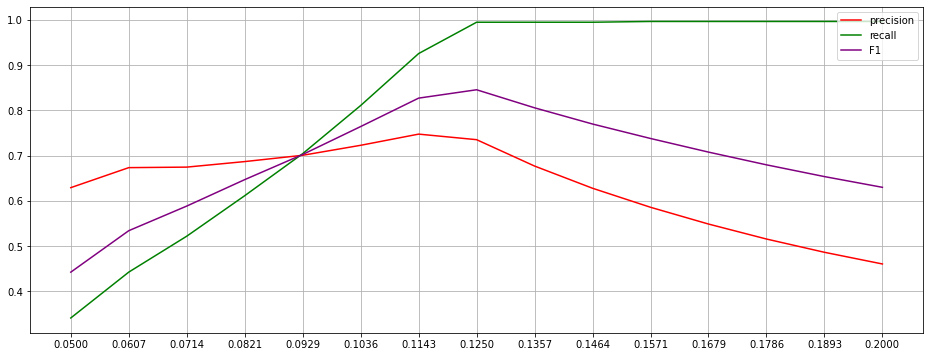

In [675]:
names = ['precision', 'recall', 'F1']
plt.figure(figsize=(16,6))
plt.plot(t,precisions,'r',label=names[0])
plt.plot(t,recalls,'g',label=names[1])
plt.plot(t,f1,'purple',label=names[2])
plt.legend(loc='upper right')
plt.xticks(ticks=np.linspace(0.05,0.2,15))
plt.grid(True)
plt.show()

### DBSCAN

DBSCAN is a simple clustering algorithm. It has two params: epsilon and min samples, what are those?
min-samples = 3

![title](dbscan.png)

In [734]:
from sklearn.cluster import DBSCAN

In [757]:
clusters = DBSCAN(eps=1, min_samples=100).fit(df_std)
np.unique(clusters.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([ 736, 3073, 1165,  976,  135,  125,  195], dtype=int64))

In [758]:
predicted_anomalies_norm = df_std[clusters.labels_==-1]
det_anomalies_norm  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_norm.index)))
print('# of detected anomalies:', det_anomalies_norm)
print(f'That is {det_anomalies_norm/len(true_anomalies)}% of all anomalies')

# of detected anomalies: 303
That is 0.5118243243243243% of all anomalies


### Isolation Forest

![title](IsolationForest1.png)
![title](IsolationForest2.png)

In [1556]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(df_std)
labels_if = clf.predict(df_std)
np.unique(labels_if, return_counts=True) #-1 for outliers 

(array([-1,  1]), array([1011, 5394], dtype=int64))

In [1560]:
predicted_anomalies_if = df_std[labels_if==-1]
det_anomalies_if  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_if.index)))
print('# of detected anomalies:', det_anomalies_if)
print(f'That is {det_anomalies_if/len(true_anomalies)}% of all anomalies')
precision = det_anomalies_if/np.sum(np.unique(kmeans_6.labels_,return_counts=True)[1][[1,4]])
recall = det_anomalies_if/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1) 

# of detected anomalies: 585
That is 0.9881756756756757% of all anomalies
Precision: 0.8024691358024691 Recall: 0.9881756756756757 F1: 0.8856926570779713


# Lecture 3

Catboost article: [link](https://arxiv.org/abs/1706.09516) (Cat - for categorical :D )

### Transforming categorical features to numerical
We are going to skip the obvious things like 

In [1575]:
letters = np.hstack(['a','b','c','d','a','c']*100000)

In [1576]:
%%timeit
unique = np.unique(letters,return_inverse=True)
encoded = np.zeros((len(letters),len(unique[0])))
encoded[np.arange(len(letters)),unique[1]] = 1
encoded

51.6 ms ± 7.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


'test_1' 0 (2 + prior)/(6 + 1)
'test_1' 0 2 (2 + prior)/(6 + 1)
'test_1' 1 1 (1 + prior)/(6 + 1)
'test_1' 2 3 (3 + prior)/(6 + 1)
'test_1' 2 3 (3 + prior)/(6 + 1)
'test_1' 2 3 (3 + prior)/(6 + 1)

In [ ]:
test_feature_1:
'test_1' = (2+prior)/(5+1)
'test_1'= (2+prior)/(5+1)
'test_2' = (5+prior)/(5+1)
'test_2' = (5+prior)/(5+1)
'test_2' = (5+prior)/(5+1)
'test_2' = (5+prior)/(5+1)
'test_2' = (5+prior)/(5+1)

<b>Catboost:</b> transforming categorical features to numerical generally includes the following stages:
1. Permutating the set of input objects in a random order.
2. Converting the <b>label</b> value from a floating point to an integer.
3. Transforming categorical features to numerical features:
* Borders: Calculating ctr for the i-th bucket (): ![Borders](Images/borders.svg)
    * <i>countInClass</i> is how many times the label value exceeded  for objects with the current categorical feature value. It only counts objects that already have this value calculated (calculations are made in the order of the objects after shuffling).
    * <i>totalCount</i> is the total number of objects (up to the current one) that have a feature value matching the current one.
    * <i>prior</i> is a number (constant) defined by the starting parameters.
* Buckets: Calculating ctr for the i-th bucket (, creates  buckets): ![Borders](Images/buckets.svg)
    * <i>countInClass</i> is how many times the label value was equal to  for objects with the current categorical feature value. It only counts objects that already have this value calculated (calculations are made in the order of the objects after shuffling).
    * <i>totalCount/<i> is the total number of objects (up to the current one) that have a feature value matching the current one.
    * <i>prior</i> is a number (constant) defined by the starting parameters.
* BinarizedTargetMeanValue: ![Borders](Images/BinarizedTargetMeanValue.svg)
    * <i>countInClass</i> is the ratio of the sum of the label value integers for this categorical feature to the maximum label value integer ().
    * <i>totalCount</i> is the total number of objects that have a feature value matching the current one.
    * <i>prior</i> is a number (constant) defined by the starting parameters.
* <b>Counter</b> (training dataset): ![Borders](Images/Counter.svg)
    * <i>curCount</i> is the total number of objects in the training dataset with the current categorical feature value.
    * <i>maxCount</i> the number of objects in the training dataset with the most frequent feature value.
    * <i>prior</i> is a number (constant) defined by the starting parameters.

### DBSCAN (picking the right parameters)

#### Picking the number of neighbours is made analytically - the larger the number, less clusters we will have (for the purposes of anomaly detection we can't have too many clusters 

#### Picking the epsilon parameter - nearest neighbors 


In [1293]:
from sklearn.neighbors import NearestNeighbors

In [1295]:
neigh = NearestNeighbors(n_neighbors=2) #2 includes the current one 
nbrs = neigh.fit(df_std)
distances, indices = nbrs.kneighbors(df_std)

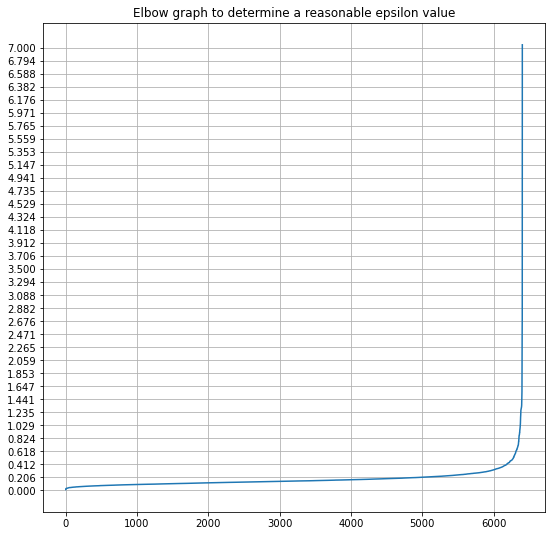

In [1303]:
distances = np.sort(distances, axis=0)
plt.figure(figsize=(9,9))
plt.plot(distances)
plt.yticks(ticks=np.linspace(0,7,35))
plt.grid(True)
plt.title('Elbow graph to determine a reasonable epsilon value')
plt.show()

In [1501]:
clusters_dbscan = DBSCAN(eps=0.6, min_samples=100).fit(df_std)
np.unique(clusters_dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3], dtype=int64),
 array([2330,  576,  637, 2236,  626], dtype=int64))

### Regarding the number of neighbours - looking at the data (SEE t-sne diagram)  I would pick a parameter which gives us 4 clusters of normal observations) - that's ~100, however, let's validate this heory by running through our data 

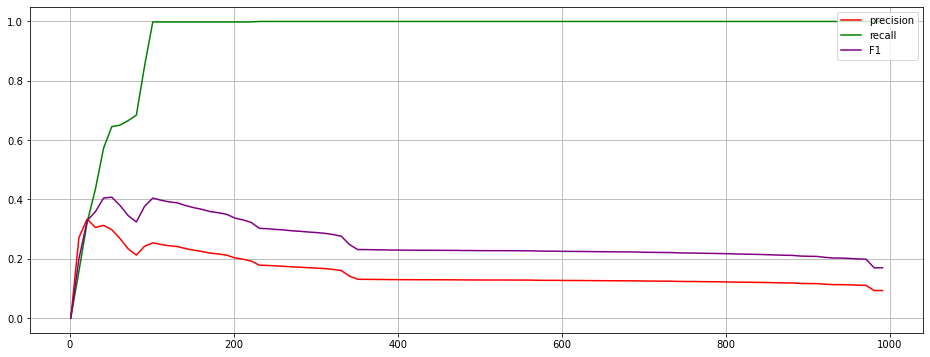

In [1336]:
precisions = []
recalls = []
f1 = []
t = range(1,1000,10)
for i in t:
    clusters = DBSCAN(eps=0.6, min_samples=i).fit(df_std)
    predicted_anomalies_dbscan = df_std[clusters.labels_==-1]
    if len(predicted_anomalies_dbscan) == 0:
        precisions.append(0)
        recalls.append(0)
        f1.append(0)
        continue
    det_anomalies_dbscan  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_dbscan.index)))
    precisions.append(det_anomalies_dbscan/len(predicted_anomalies_dbscan))
    recalls.append(det_anomalies_dbscan/len(true_anomalies))
    f1.append(2*((precisions[-1]*recalls[-1])/(precisions[-1]+recalls[-1])))

names = ['precision', 'recall', 'F1']
plt.figure(figsize=(16,6))
plt.plot(t,precisions,'r',label=names[0])
plt.plot(t,recalls,'g',label=names[1])
plt.plot(t,f1,'purple',label=names[2])
plt.legend(loc='upper right')
plt.xticks(ticks=np.linspace(1,1000,100))
plt.grid(True)
plt.show()

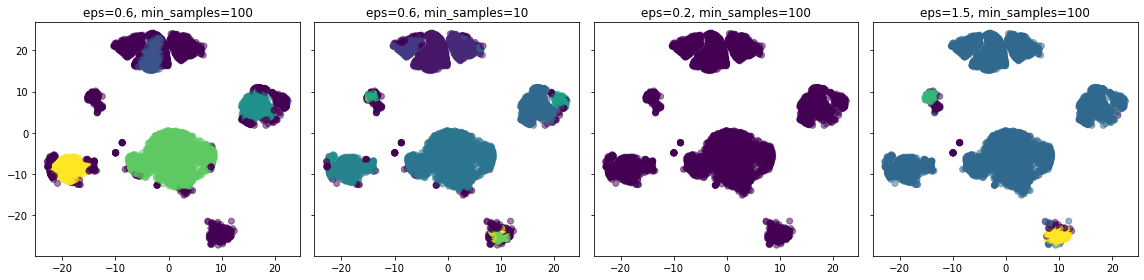

In [1518]:
clusters_dbscan = DBSCAN(eps=0.6, min_samples=100).fit(df_std)
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True,figsize=(16, 4))
axs[0].scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=clusters_dbscan.labels_)
axs[0].title.set_text('eps=0.6, min_samples=100')
clusters_dbscan = DBSCAN(eps=0.6, min_samples=10).fit(df_std)
axs[1].scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=clusters_dbscan.labels_)
axs[1].title.set_text('eps=0.6, min_samples=10')
clusters_dbscan = DBSCAN(eps=0.2, min_samples=100).fit(df_std)
axs[2].scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=clusters_dbscan.labels_)
axs[2].title.set_text('eps=0.2, min_samples=100')
clusters_dbscan = DBSCAN(eps=1.5, min_samples=100).fit(df_std)
axs[3].scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=clusters_dbscan.labels_)
axs[3].title.set_text('eps=1.5, min_samples=100')
plt.show()

In [1562]:
clusters_dbscan_min_clust = DBSCAN(eps=1.5, min_samples=100).fit(df_std)
np.unique(clusters_dbscan_min_clust.labels_, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([  72, 5655,  253,  425], dtype=int64))

In [1564]:
predicted_anomalies_dbscan = df_std[(clusters_dbscan_min_clust.labels_==-1) | (clusters_dbscan_min_clust.labels_==1) | (clusters_dbscan_min_clust.labels_==2)]
det_anomalies_dbscan  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_dbscan.index)))
print('# of detected anomalies:', det_anomalies_dbscan)
print(f'That is {det_anomalies_dbscan/len(true_anomalies)}% of all anomalies')
precision = det_anomalies_dbscan/np.sum(np.unique(kmeans_6.labels_,return_counts=True)[1][[1,4]])
recall = det_anomalies_dbscan/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1) 

# of detected anomalies: 590
That is 0.9966216216216216% of all anomalies
Precision: 0.8093278463648834 Recall: 0.9966216216216216 F1: 0.8932626797880393


### It is s a nice heuristic for the finding the optimal epsilon value, however is really the optimal one? We could go with the standard grd search approach 

### Simulated annealing
#### Question: what is annealing in metallurgy?
We are going to start with the initial state which is the best solution we have determined so far to find out if we can do any better (Usually, it can be started from a random position)

![Simulated Annealing](Images/annealing.gif)

In [ ]:
exp(-delta/temperature)

In [1582]:
np.exp(-10/90)

0.8948393168143698

In [ ]:
state = (eps,min_samples)
delta = 


In [1417]:
#initial state for us is the the e = 0.6, min_samples = 100
def simulated_annealing(initial_state):
    # HYPERPARAMETERS:
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    neighborhood =(0.05,20) #should be balanced, there is way to decrease it over time 
    range_of_values = ((0,10),(0,1000)) #The possible range of values   
    
    current_temp = initial_temp

    # Start by initializing the current state with the initial state
    state = initial_state
    f1 = get_f1(state)

    while current_temp > final_temp:
        neighbor = get_neighbor(state,neighborhood,range_of_values)

        # Check if neighbor is best so far
        neighbor_f1 = get_f1(neighbor)b
        f1_diff = neighbor_f1 - f1 

        # if the new solution is better, accept it
        if f1_diff > 0:
            state = neighbor
            f1 = neighbor_f1
        # if the new solution is not better, accept it with a probability of e^(-cost/temp)
        else:
            if np.random.uniform(0, 1) < np.exp(-f1_diff*1000 / current_temp):
                state = neighbor
                f1 = neighbor_f1
        # decrement the temperature
        current_temp -= alpha

    return state,f1

def get_f1(state):
    clusters = DBSCAN(eps=state[0], min_samples=state[1]).fit(df_std)
    predicted_anomalies_dbscan = df_std[clusters.labels_==-1]
    if len(predicted_anomalies_dbscan) == 0:
        return 0 
    det_anomalies_dbscan = len(set(true_anomalies.index).intersection(set(predicted_anomalies_dbscan.index)))
    precision = det_anomalies_dbscan/len(predicted_anomalies_dbscan)
    recall = det_anomalies_dbscan/len(true_anomalies)
    if precision == 0 or recall ==0:
        return 0
    return 2*((precision*recall)/(precision+recall))
    
def get_neighbor(state,neighborhood,range_of_values):
    eps = np.random.uniform(max(range_of_values[0][0],state[0]-neighborhood[0]),min(range_of_values[0][1],state[0]+neighborhood[0]),1)[0]
    min_samples = np.random.uniform(max(range_of_values[1][0],state[1]-neighborhood[1]),min(range_of_values[1][1],state[0]+neighborhood[1]),1)[0]
    return (eps,min_samples)

In [1583]:
state,f1 = simulated_annealing((1,100))

KeyboardInterrupt: 

### OPTICS
Improved DBSCAN that attempts to automatically detect the epsilon

In [ ]:
from sklearn.cluster import OPTICS

In [1552]:
clusters_optics = OPTICS(min_samples=70).fit(df_std)

In [1555]:
np.unique(clusters_optics.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5]),
 array([ 744, 3082, 1179, 1028,  127,  106,  139], dtype=int64))

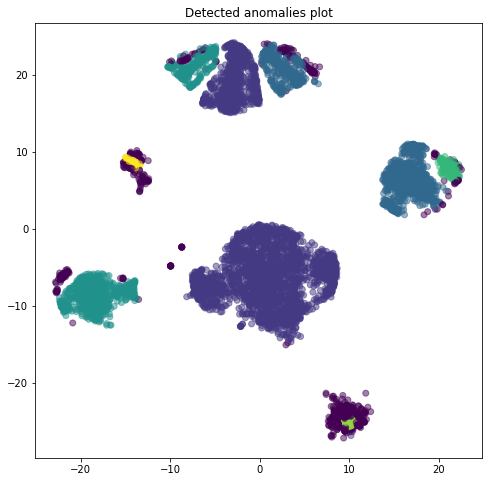

In [1554]:
plt.figure(figsize=(8, 8))
plt.scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=clusters_optics.labels_)
plt.title('Detected anomalies plot')
plt.show()

### k-means
Since our anomalies are distributed quite densely, would it make sense just o

In [1436]:
 from sklearn.cluster import KMeans
kmeans_6 = KMeans(n_clusters=6, random_state=0).fit(df_std)

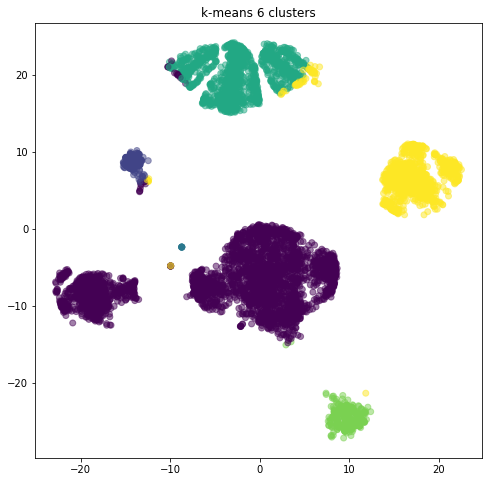

In [1437]:
plt.figure(figsize=(8, 8))
plt.scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=kmeans_6.labels_)
plt.title('k-means 6 clusters')
plt.show()

In [1434]:
 from sklearn.cluster import KMeans
kmeans_8 = KMeans(n_clusters=8, random_state=0).fit(df_std)

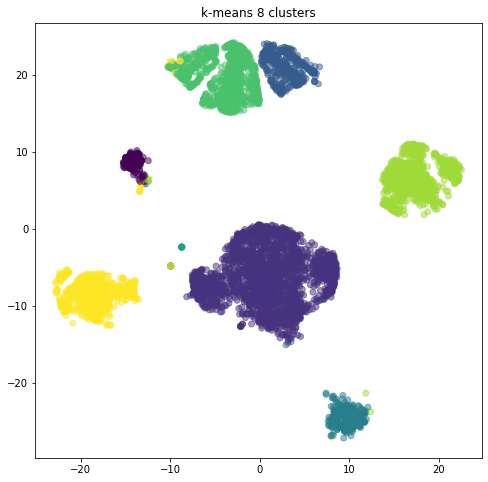

In [1435]:
plt.figure(figsize=(8, 8))
plt.scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=kmeans_8.labels_)
plt.title('k-means 8 clusters')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(x_tsne_500[0],x_tsne_500[1],alpha=0.5,c=kmeans.labels_)
plt.title('Detected anomalies plot')
plt.show()

#### Going with 6 clusters

In [1441]:
anomalous_clusters = kmeans_6.labels_[((df_std.index>='2019-07-08 18:39:22') & (df_std.index<='2019-07-08 18:42:32')) | 
                        ((df_std.index>='2019-07-08 18:45:49') & (df_std.index<='2019-07-08 18:46:51')) | 
                        ((df_std.index>='2019-07-08 19:07:37') & (df_std.index<='2019-07-08 19:10:45')) | 
                        ((df_std.index>='2019-07-08 19:16:24') & (df_std.index<='2019-07-08 19:19:15'))]
anomalous_clusters

array([0, 0, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [1559]:
precision = np.sum((anomalous_clusters==1)|(anomalous_clusters==4))/np.sum(np.unique(kmeans_6.labels_,return_counts=True)[1][[1,4]])
recall = np.sum((anomalous_clusters==1)|(anomalous_clusters==4))/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1)

Precision: 0.8079561042524005 Recall: 0.9949324324324325 F1: 0.8917486752460257


In [1558]:
#The results from mixture model: Precision: 0.8241134751773049 Recall:0.981418918918919 F1: 0.8959136468774094
#The results from isolation forest: Precision: 0.8024691358024691 Recall: 0.9881756756756757 F1: 0.8856926570779713
#The results from dbscan: Precision: 0.8093278463648834 Recall: 0.9966216216216216 F1: 0.8932626797880393

## Lecture 4

## Autoencoders

![Autoencoders](Images/ae.png)

In [2100]:
class Basic_Autoencoder(nn.Module):
    def __init__(self): #, dropout=0.1
        super(Basic_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(8, 6),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(6, 4),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(4,4))  
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 6),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(6, 8),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(8,8)) 
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [2101]:
data = torch.tensor(df_std.values).float().to(cuda0)
batches = torch.split(data,32)

In [2151]:
autoencoder = Basic_Autoencoder().to(cuda0)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(),weight_decay=1e-5)
for epoch in range(1):
    for batch in batches:
        optimizer.zero_grad()
        output = autoencoder(batch)
        loss = mse_loss(output,batch)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
    print(torch.sum(torch.linalg.norm(batch-output,dim=1)))
    print(loss.item())

tensor(11.2593, device='cuda:0', grad_fn=<SumBackward0>)
0.6554263234138489


In [2152]:
predictions = autoencoder(data)

In [2153]:
dist = torch.linalg.norm(predictions-data,dim=1).cpu().detach().numpy()

In [2154]:
len(predicted_anomalies_auto)

705

In [2155]:
predicted_anomalies_auto = df_std[dist >= np.quantile(dist, 0.89)]
det_anomalies_auto  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto.index)))
det_anomalies_auto  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto.index)))
print('# of detected anomalies:', det_anomalies_auto )
print(f'That is {det_anomalies_auto/len(true_anomalies)}% of all anomalies') #338

# of detected anomalies: 556
That is 0.9391891891891891% of all anomalies


In [2156]:
precision = det_anomalies_auto/len(predicted_anomalies_auto)
recall = det_anomalies_auto/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1)

Precision: 0.7886524822695036 Recall: 0.9391891891891891 F1: 0.8573631457208943


In [2141]:
#The results from mixture model: Precision: 0.8241134751773049 Recall:0.981418918918919 F1: 0.8959136468774094
#The results from isolation forest: Precision: 0.8024691358024691 Recall: 0.9881756756756757 F1: 0.8856926570779713
#The results from dbscan: Precision: 0.8093278463648834 Recall: 0.9966216216216216 F1: 0.8932626797880393

tensor([3.0183, 2.5221, 3.0204,  ..., 1.1055, 3.1984, 2.9567], device='cuda:0',
       grad_fn=<CopyBackwards>)

### PyOD (Python toolkit for detecting outlying objects)

In [2244]:
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
autoencoder_pyod = AutoEncoder(hidden_neurons = [6, 4, 4, 6],epochs=9)

In [2245]:
autoencoder_pyod.fit(df_std)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_48 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_70 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_49 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_71 (Dense)             (None, 6)                 54        
_________________________________________________________________
dropout_50 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_72 (Dense)             (None, 4)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=9,
      hidden_activation='relu', hidden_neurons=[6, 4, 4, 6],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000021297C2E948>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [2249]:
predictions = autoencoder_pyod.predict(df_std)

In [2250]:
np.sum(predictions)

641

In [2251]:
predicted_anomalies_auto_pyod = df_std[predictions==1]
det_anomalies_auto_pyod  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto_pyod.index)))
det_anomalies_auto_pyod  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto_pyod.index)))
print('# of detected anomalies:', det_anomalies_auto_pyod)
print(f'That is {det_anomalies_auto_pyod/len(true_anomalies)}% of all anomalies') #338

precision = det_anomalies_auto_pyod/len(predicted_anomalies_auto_pyod)
recall = det_anomalies_auto_pyod/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1)

# of detected anomalies: 517
That is 0.8733108108108109% of all anomalies
Precision: 0.8065522620904836 Recall: 0.8733108108108109 F1: 0.8386050283860503


In [2252]:
model_VAE = VAE(encoder_neurons=[6,4], decoder_neurons=[4,6],epochs=10,latent_dim=2)

In [2234]:
model_VAE.fit(df_std)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 8)            72          input_5[0][0]                    
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 6)            54          dense_53[0][0]                   
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 6)            0           dense_54[0][0]                   
____________________________________________________________________________________________

VAE(batch_size=32, capacity=0.0, contamination=0.1, decoder_neurons=[4, 6],
  dropout_rate=0.2, encoder_neurons=[6, 4], epochs=10, gamma=1.0,
  hidden_activation='relu', l2_regularizer=0.1, latent_dim=2,
  loss=<function mean_squared_error at 0x0000021297C2E948>,
  optimizer='adam', output_activation='sigmoid', preprocessing=True,
  random_state=None, validation_size=0.1, verbose=1)

In [2235]:
predictions_vae = model_VAE.predict(df_std)

In [2236]:
np.sum(predictions_vae)

639

In [2237]:
predicted_anomalies_auto_vae = df_std[predictions_vae==1]
det_anomalies_auto_vae  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto_vae.index)))
det_anomalies_auto_vae   = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto_vae.index)))
print('# of detected anomalies:', det_anomalies_auto_vae)
print(f'That is {det_anomalies_auto_vae/len(true_anomalies)}% of all anomalies') #338

precision = det_anomalies_auto_vae/len(predicted_anomalies_auto_vae)
recall = det_anomalies_auto_vae/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1)

# of detected anomalies: 515
That is 0.8699324324324325% of all anomalies
Precision: 0.8059467918622848 Recall: 0.8699324324324325 F1: 0.8367181153533713


### Simple Contrastive Learning

##### Warning: For the sake of time we are not splitting the dataset, however, it should be normally done for validation purposes

In [2265]:
#data = torch.tensor(df_std.values).float().to(cuda0)
t = torch.ones(data.shape[0],device=cuda0)
t[((df_std.index>='2019-07-08 18:39:22') & (df_std.index<='2019-07-08 18:42:32')) | 
                        ((df_std.index>='2019-07-08 18:45:49') & (df_std.index<='2019-07-08 18:46:51')) | 
                        ((df_std.index>='2019-07-08 19:07:37') & (df_std.index<='2019-07-08 19:10:45')) | 
                        ((df_std.index>='2019-07-08 19:16:24') & (df_std.index<='2019-07-08 19:19:15'))] = -1
t_batches = torch.split(t,32)

In [2416]:
-1*(torch.square(torch.tensor([1.0])-torch.tensor([1.01]))-1)

tensor([0.9999])

In [2411]:
torch.maximum(torch.tensor([0]),-1*torch.sqrt(torch.sum(torch.square(torch.tensor([1.0])-torch.tensor([1.001])),axis=-1))-1)

tensor([0.])

In [2296]:
def contrastive_loss(t,real,pred):
    return torch.sum(torch.maximum(torch.tensor([0],device=cuda0),t*(torch.sqrt(torch.sum(torch.square(real-pred),axis=-1))-1)))

In [2344]:
contrastive = Basic_Autoencoder().to(cuda0)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(contrastive.parameters(),weight_decay=1e-5)
for epoch in range(20):
    for i,batch in enumerate(batches):
        optimizer.zero_grad()
        output = autoencoder(batch)
        loss = contrastive_loss(t_batches[i],batch,output)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
    print(torch.sum(torch.linalg.norm(batch-output,dim=1)))
    print(loss.item())

tensor(11.0783, device='cuda:0', grad_fn=<SumBackward0>)
6.078310966491699
tensor(11.2782, device='cuda:0', grad_fn=<SumBackward0>)
6.278236389160156
tensor(10.9936, device='cuda:0', grad_fn=<SumBackward0>)
5.993624687194824
tensor(11.0969, device='cuda:0', grad_fn=<SumBackward0>)
6.09690523147583
tensor(11.0659, device='cuda:0', grad_fn=<SumBackward0>)
6.065913200378418
tensor(11.2010, device='cuda:0', grad_fn=<SumBackward0>)
6.200978755950928
tensor(11.0008, device='cuda:0', grad_fn=<SumBackward0>)
6.000810146331787
tensor(10.9388, device='cuda:0', grad_fn=<SumBackward0>)
5.938759803771973
tensor(11.2218, device='cuda:0', grad_fn=<SumBackward0>)
6.221819877624512
tensor(11.2393, device='cuda:0', grad_fn=<SumBackward0>)
6.239267826080322
tensor(11.5235, device='cuda:0', grad_fn=<SumBackward0>)
6.5235371589660645
tensor(11.1187, device='cuda:0', grad_fn=<SumBackward0>)
6.118651390075684
tensor(11.0865, device='cuda:0', grad_fn=<SumBackward0>)
6.086544990539551
tensor(11.2221, device='c

In [2345]:
predictions = contrastive(data)

In [2346]:
dist = torch.linalg.norm(predictions-data,dim=1).cpu().detach().numpy()

In [2347]:
predicted_anomalies_auto = df_std[dist >= np.quantile(dist, 0.89)]
det_anomalies_auto  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto.index)))
det_anomalies_auto  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_auto.index)))
print('# of detected anomalies:', det_anomalies_auto )
print(f'That is {det_anomalies_auto/len(true_anomalies)}% of all anomalies') #338

# of detected anomalies: 575
That is 0.9712837837837838% of all anomalies


In [2348]:
precision = det_anomalies_auto/len(predicted_anomalies_auto)
recall = det_anomalies_auto/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1)

Precision: 0.8156028368794326 Recall: 0.9712837837837838 F1: 0.8866615265998458


In [ ]:
#The results from mixture model: Precision: 0.8241134751773049 Recall:0.981418918918919 F1: 0.8959136468774094
#The results from isolation forest: Precision: 0.8024691358024691 Recall: 0.9881756756756757 F1: 0.8856926570779713
#The results from dbscan: Precision: 0.8093278463648834 Recall: 0.9966216216216216 F1: 0.8932626797880393

### Negative Sampling

In [2801]:
#Generate negative samples from several random distributions
n = 1
n_samples = int(len(data)/n)
samples = []
for i in range(n):
    #gen random cov_matrix with random expectation and random std
    dist = MultivariateNormal(torch.mean(torch.tensor(true_anomalies.values,device=cuda0),axis=0),torch.diag(torch.std(torch.tensor(true_anomalies.values,device=cuda0),axis=0)))
    sample = dist.sample([n_samples]).to(cuda0).float()
    samples.append(sample)

In [2802]:
negative_samples = torch.cat((samples))

In [2803]:
negative_samples = torch.cat((negative_samples,torch.ones((negative_samples.shape[0],1),device=cuda0)),axis=1)

In [2804]:
samples = torch.cat((data,torch.zeros((data.shape[0],1),device=cuda0)),axis=1)

In [2805]:
training_data = torch.cat((samples,negative_samples))

In [ ]:
#torch.split

In [2806]:
#we shall split by batches together with label as it is randomized
training_batches = torch.utils.data.random_split(training_data,[30]*int(training_data.shape[0]/30))

In [2807]:
training_data[training_batches[0].indices,:8].shape

torch.Size([30, 8])

In [2878]:
class NegativeSampling(nn.Module):
    def __init__(self): #, dropout=0.1
        super(NegativeSampling, self).__init__()
        self.classification = nn.Sequential(
            nn.Linear(8, 10),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(10, 1),
            nn.Dropout(p=0.2))   
        
    def forward(self, x):
        return torch.sigmoid(self.classification(x)) #wrap it in sigmoid function

In [2879]:
negative_sampling = NegativeSampling().to(cuda0)
bce_loss = nn.BCELoss()
optimizer = torch.optim.Adam(negative_sampling.parameters(),weight_decay=1e-5)
for epoch in range(2):
    for batch in training_batches:
        optimizer.zero_grad()
        output = negative_sampling(training_data[batch.indices,:8])
        loss = bce_loss(output,training_data[batch.indices,8:])
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
    print(loss.item())

0.346198171377182
0.3086095452308655


In [2880]:
pred = negative_sampling(data).detach().cpu().numpy()

In [2881]:
predicted_anomalies_neg = df_std[pred >= np.quantile(pred, 0.90)]
det_anomalies_neg  = len(set(true_anomalies.index).intersection(set(predicted_anomalies_neg.index)))
det_anomalies_neg = len(set(true_anomalies.index).intersection(set(predicted_anomalies_neg.index)))
print('# of detected anomalies:', det_anomalies_neg)
print(f'That is {det_anomalies_neg/len(true_anomalies)}% of all anomalies') #338

# of detected anomalies: 565
That is 0.9543918918918919% of all anomalies


In [2882]:
np.quantile(pred, 0.90)

0.5

In [2884]:
precision = det_anomalies_neg/len(predicted_anomalies_neg)
recall = det_anomalies_neg/len(true_anomalies)
f1 = 2*((precision*recall)/(precision+recall))
print('Precision:',precision,'Recall:',recall,'F1:',f1)

Precision: 0.30213903743315507 Recall: 0.9543918918918919 F1: 0.45897644191714054


## Lecture 5, Time series anomaly detection

### What we have been avoiding so far?

In [8]:
pca_1 = PCA(n_components=1)
x_pca_1 = pca_1.fit_transform(df_std)
x_pca_1 = pd.DataFrame(x_pca_1)
x_pca_1.head()

,0
0,2.949112
1,3.003177
2,3.001418
3,2.926659
4,2.956642


In [9]:
colors = df_std.index.isin(true_anomalies.index).astype('int')

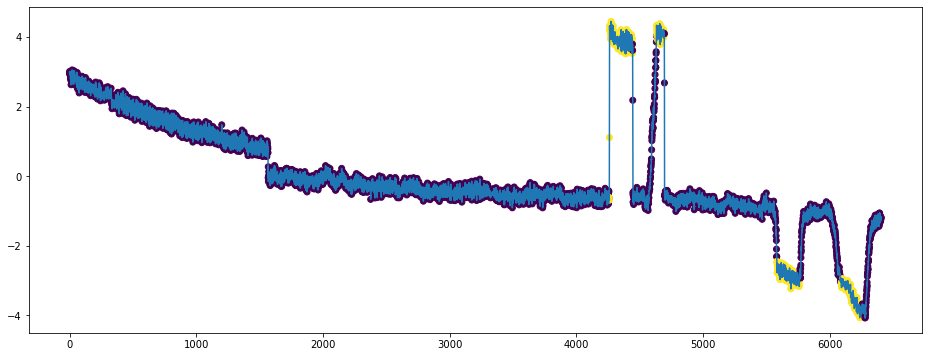

In [2894]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(df_std)),x_pca_1.values)
plt.scatter(np.arange(len(df_std)),x_pca_1.values,alpha=1,c=colors)
plt.show()

#### Let's plot the missing parts

- Slow defect appearing: 18:44:36-18:45:49
- Slow defect appearing: 19:06:57-19:07:37
- Slow defect disappearing: 19:10:45-19:11:31
- Slow defect appearing: 19:14:40-19:16:24
- Slow defect disappearing: 19:19:15-19:21:16

In [10]:
colors[((df_std.index>='2019-07-08 18:44:36') & (df_std.index<='2019-07-08 18:45:49')) | 
                        ((df_std.index>='2019-07-08 19:06:57') & (df_std.index<='2019-07-08 19:07:37')) | 
                        ((df_std.index>='2019-07-08 19:10:45') & (df_std.index<='2019-07-08 19:11:31')) | 
                        ((df_std.index>='2019-07-08 19:14:40') & (df_std.index<='2019-07-08 19:16:24')) |
                        ((df_std.index>='2019-07-08 19:19:15') & (df_std.index<='2019-07-08 19:21:16'))] = 2

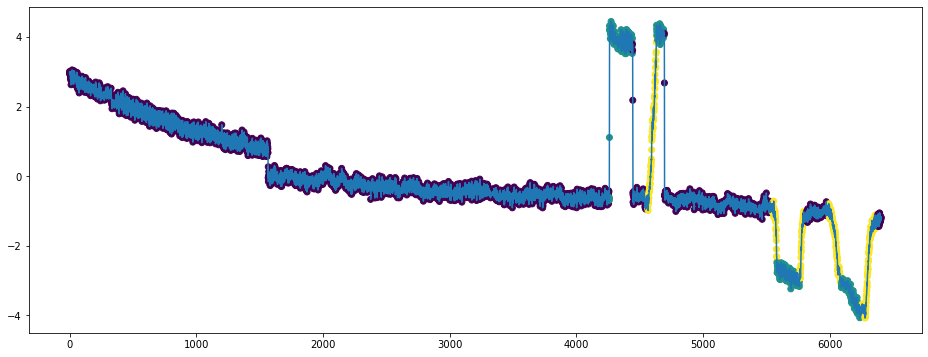

In [2897]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(df_std)),x_pca_1.values)
plt.scatter(np.arange(len(df_std)),x_pca_1.values,alpha=1,c=colors)
plt.show()

#### The Simplest autoregressive model - Simple Moving Average (SMA) on PCA data

In [ ]:
#SMA = (A1 + A2 +...+ An)/n where A is the average for a period and n is the number of periods we are looking back 

In [ ]:
# 2 in the Exponential Moving Average formula above C - is the value for the current periodis the smoothing parameter, 

In [2901]:
df_std.index

Index(['2019-07-08 17:02:14', '2019-07-08 17:02:32', '2019-07-08 17:02:45',
       '2019-07-08 17:02:46', '2019-07-08 17:02:47', '2019-07-08 17:02:48',
       '2019-07-08 17:02:49', '2019-07-08 17:02:50', '2019-07-08 17:02:52',
       '2019-07-08 17:02:53',
       ...
       '2019-07-08 19:21:41', '2019-07-08 19:21:42', '2019-07-08 19:21:43',
       '2019-07-08 19:21:44', '2019-07-08 19:21:46', '2019-07-08 19:21:47',
       '2019-07-08 19:21:48', '2019-07-08 19:21:49', '2019-07-08 19:21:50',
       '2019-07-08 19:21:51'],
      dtype='object', name='datetime', length=6405)

#### Warning: simplification below, instead of real periods we are just taking <i>l</i> observations

In [245]:
l_period = 5 #the len of observations with the current implementation should be divisible by that number, e.g. 15 could work as well
n_splits = int(len(df_std)/l_period)
window = 30 #a bit exegarrated for demonstration purposes

In [246]:
split_data = np.split(x_pca_1.values,n_splits)

In [247]:
period_averages = np.array(list(map(np.mean,split_data)))

In [248]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [249]:
ma = moving_average(period_averages,window)

In [250]:
t_ma = np.arange(len(ma))*l_period + l_period*window

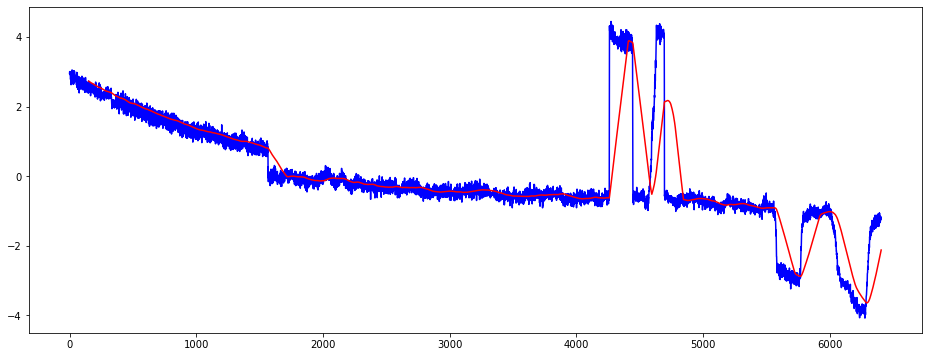

In [251]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(df_std)),x_pca_1.values,color='blue')
plt.plot(t_ma,ma,color='red')
plt.show()

#### Exponential Moving Average on PCA data

In [ ]:
#Vt = B*Vt-1 +(1-B)*Ot (Observation at time t)

In [2985]:
#days = #window
#B = f(days) 
B = 0.98
ema =[x_pca_1.values[0]]
for i in np.arange(1,len(x_pca_1)):
    ema.append(B*ema[-1]+(1-B)*x_pca_1.values[i])

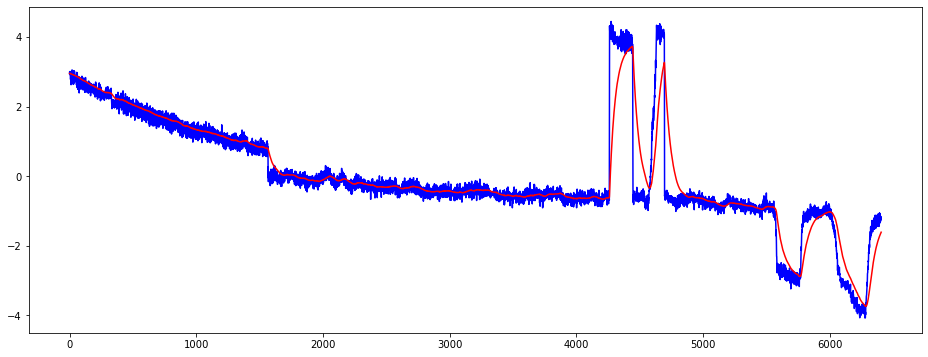

In [2986]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(df_std)),x_pca_1.values,color='blue')
plt.plot(np.arange(len(df_std)),ema,color='red')
plt.show()

#### Autoregressive Moving Average on PCA data (Consider SARIMA for the applications with Seasonality)
[Theory](https://people.duke.edu/~rnau/arimrule.htm)

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
-------------------------
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing. The first (and most important) step in fitting an ARIMA model is the determination of the order of differencing needed to <b>stationarize</b> the series.
- q: The size of the moving average window, also called the order of moving average.
-------------------------
If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.


In [13]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

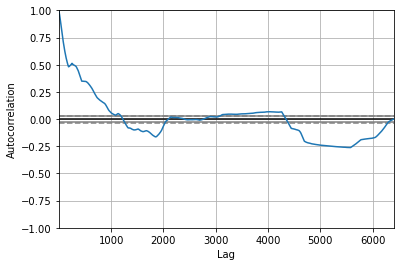

In [12]:
autocorrelation_plot(x_pca_1)

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                 6405
Model:                ARIMA(10, 1, 2)   Log Likelihood                2333.205
Date:                Wed, 03 Feb 2021   AIC                          -4640.411
Time:                        08:24:05   BIC                          -4552.470
Sample:                             0   HQIC                         -4609.972
                               - 6405                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2733      0.631     -0.433      0.665      -1.511       0.964
ar.L2          0.0327      0.564      0.058      0.954      -1.073       1.139
ar.L3         -0.0152      0.263     -0.058      0.9

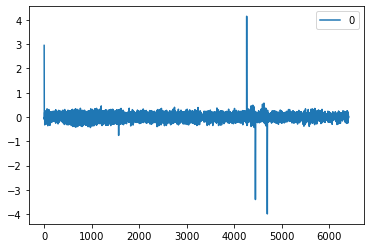

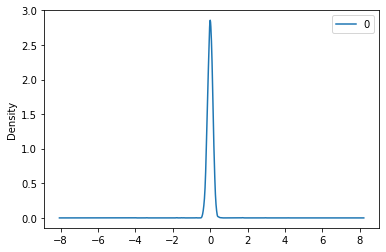

                 0
count  6405.000000
mean     -0.000501
std       0.172075
min      -3.992103
25%      -0.093984
50%       0.003168
75%       0.094485
max       4.150274


In [55]:
# fit model
model = ARIMA(x_pca_1, order=(10,1,2))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [112]:
res_outliers = np.where((model_fit.resid>np.quantile(model_fit.resid,0.999)) | (model_fit.resid<np.quantile(model_fit.resid,0.001)))

In [113]:
len(res_outliers[0])

14

In [114]:
predicted = model_fit.predict(1,len(df_std))

In [115]:
predicted.shape

(6405,)

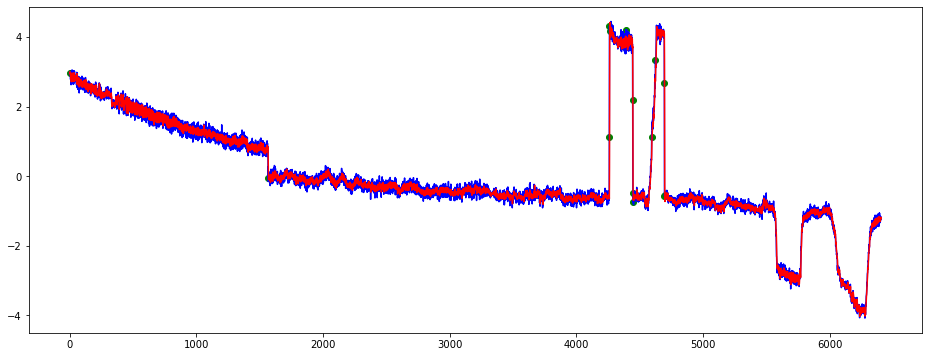

In [116]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(df_std)),x_pca_1.values,color='blue')
plt.plot(np.arange(len(df_std))+1,predicted,color='red')
plt.scatter(res_outliers[0],x_pca_1.values[res_outliers[0]],alpha=1,c='green')
plt.show()

In [67]:
# BTW, There is an auto-arima piece: from pyramid.arima import auto_arima

#### VAR - Vector Autoregressive Model
Multivariate extension to ARIMA

From [link](https://towardsdatascience.com/anomaly-detection-in-multivariate-time-series-with-var-2130f276e5e9):

AR model extends the univariate autoregressive (AR) model by capturing the linear relations between multiple variables. For each input series, a regression is carried out. The original variables are regressed against their own lagged values and the lagged values of other variables. In a multivariate process system with the presence of serial correlation, we use VAR models to approximate the system and monitor the residuals as a serially independent series

In [117]:
from statsmodels.tsa.api import VAR

In [118]:
model = VAR(df_std)

C:\Users\akabirov003\.conda\envs\transformers\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [119]:
results = model.fit(10)

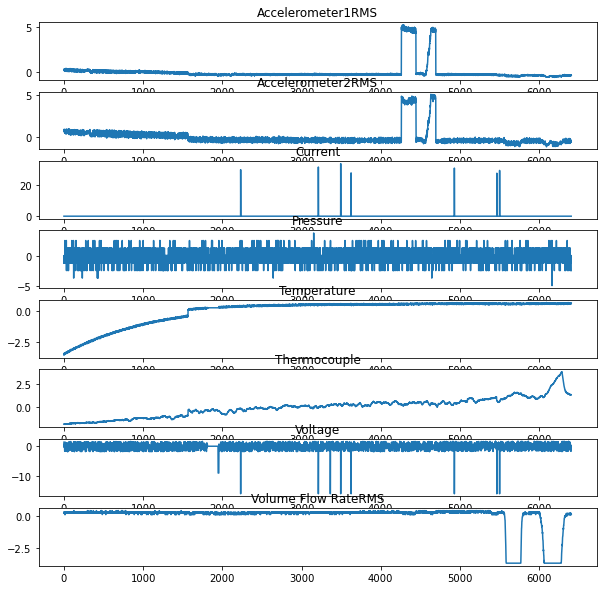

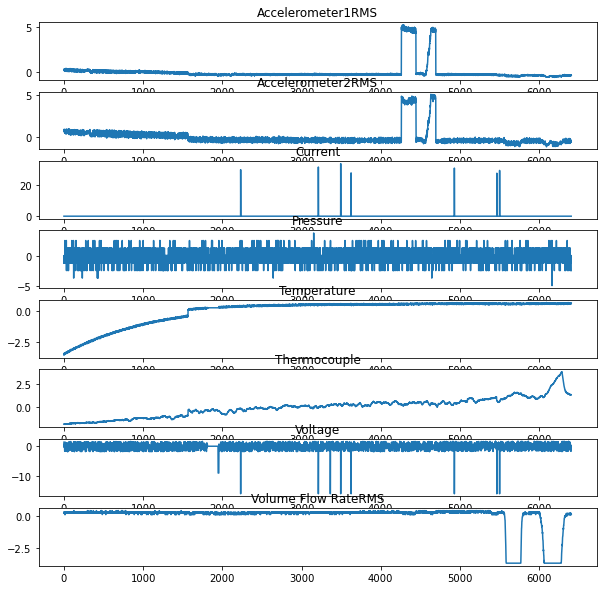

In [120]:
results.plot()

<Figure size 432x288 with 0 Axes>

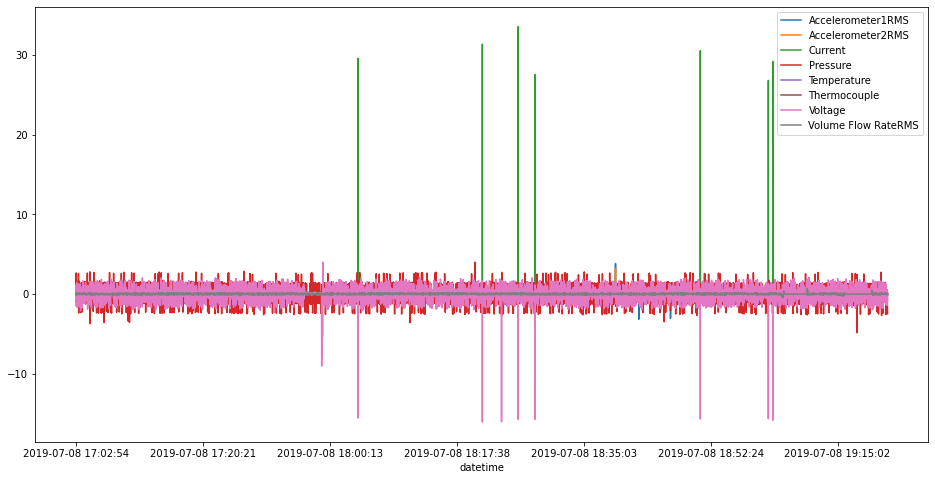

In [255]:
results.resid.plot(figsize=(16,8))

### RNN forecasting

In [128]:
lag = 10

In [ ]:
#(Batch,Sequence,Features)

In [149]:
windows = torch.tensor(np.vstack([np.expand_dims(df_std[i:i+lag],0) for i in range(0,len(df_std)-lag)]),device=cuda0).float()

In [256]:
windows.shape

torch.Size([6395, 10, 8])

In [177]:
t11_values = torch.tensor(df_std.values[10:,:],device=cuda0).float()

In [178]:
batches = torch.split(windows,32)
t11_batches = torch.split(t11_values,32)

In [213]:
class RNN_anomaly(nn.Module):
    def __init__(self): #, dropout=0.1
        super(RNN_anomaly, self).__init__()
        self.rnn = torch.nn.RNN(dropout = 0.1,input_size = 8, hidden_size=20,num_layers=2,batch_first = True) #LSTM, GRU - more advanced algos
        self.linear = torch.nn.Linear(20,8)
        
    def forward(self, x):
        return self.linear(self.rnn(x)[1][1,:,:].permute((0,1))) #the output at t_n

In [224]:
rnn_anomaly = RNN_anomaly().to(cuda0)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_anomaly.parameters(),weight_decay=1e-5)
for epoch in range(10):
    for i,batch in enumerate(batches):
        optimizer.zero_grad()
        output =rnn_anomaly(batch)
        loss = mse_loss(output,t11_batches[i])
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
    print(loss.item())


0.3777408003807068
0.3565102219581604
0.3144729733467102
0.2505298852920532
0.2497854232788086
0.2330654263496399
0.22995701432228088
0.22851788997650146
0.22447526454925537
0.23115825653076172


In [225]:
preds = rnn_anomaly(windows)

In [235]:
error = torch.torch.linalg.norm(preds-t11_values,dim=1)

In [236]:
error.shape

torch.Size([6395])

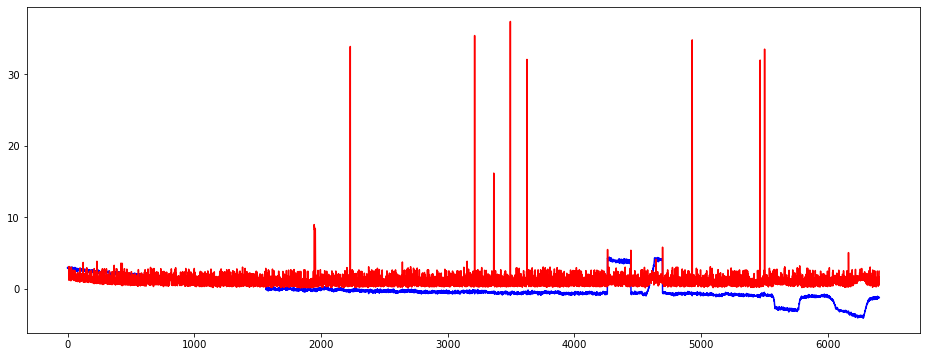

In [237]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(df_std)),x_pca_1.values,color='blue')
plt.plot(np.arange(len(df_std)-10)+10,error.detach().cpu().numpy(),color='red')
plt.show()

In [258]:
nn.functional.one_hot(torch.tensor([0,1,3,5,5,7,9,7]).long(), num_classes=10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])